# Entity resolution

Utrecht University, Applied Data Science, Master thesis

By Sander Engelberts (1422138)

May-June 2022

This notebook contains code to first process the cleaned data sets of personal record cards and passport requests into the final entity resolution input by standardising the feature names, aggregating retrieved LOD place entity data into existing features of records (and consequently dropping the records that could not be enriched), creating a blocking key for each record and only keeping the records that have minimum one candidate. Second, the designed entity resolution algorithm is run for non- and place enriched data, which takes into account (partially) missing feature values. Last, the resulting outputs are inspected with respect to their similarity value distributions and validated using a stratified random sample of candidate links as well as matches against BRP records of deceased people. 

In [2]:
# Load required packages
import os # for paths to files in operating system
import pandas as pd # for dataframes and operations on it
import numpy as np # for mathematical operations
from tqdm import tqdm # for displaying progress of operations
import jellyfish # for approximate similarity and phonetic matching of strings
import datetime # for representing dates in a standardised format
import matplotlib.pyplot as plt # for creating graphs
from scipy.spatial import distance # for calculating coordinate distances on a flat plane
from pyproj import Transformer # for coordinate reference system transformations
from haversine import haversine, Unit # for calculating coordinate distances on a spheroid
from sklearn.model_selection import StratifiedShuffleSplit # for creating a stratified random 
    # sample for validation
from scipy import stats # for statistical tests of results validation 
tqdm.pandas() # display progress of pandas operations such as apply (use progress_apply instead)

## Loading and structuring data

In [6]:
# Path to folder where I stored the data, adapt to own storage location
data_path = "E:\CBG" 

# Path to cleaned personal record cards data 
person_card_path = os.path.join(data_path, "clean_persoonskaarten.csv")

# Path to cleaned passport requests data
passport_path = os.path.join(data_path, "clean_Indische_paspoorten.csv")

# Path to unique place-province combinations which are tried to link to Wikidata and/or GeoNames
location_path = os.path.join(data_path, "merged_locations.csv") 

In [3]:
# Load cleaned personal record cards data into a dataframe
df_person_card = pd.read_csv(person_card_path, sep=",", header=0, index_col=None)

In [4]:
# Load cleaned passport requests data into a dataframe
df_passport = pd.read_csv(passport_path, sep=",", header=0, index_col=None)

C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (21,22,23,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Load Wikidata and ErfGeo Proxy queried location data 
# This will enrich enriches the currently recorded place information
df_location = pd.read_csv(location_path, sep=",", header=0, index_col=None)

In [6]:
# Only keep columns of personal record cards and passport requests that are relevant for
# the entity resolution algorithm
df_person_card.drop(columns=['Bestandsnaam CBG', 'Doosnummer', 'Onderdeel', 'Extra_plaats_info'], 
                    inplace=True, axis=1)

df_passport.drop(columns=df_passport.columns.difference(['id', 'p1_voornaam', 'p1_voorvoegsel', 
                                                         'p1_achternaam', 'p1_gebdat', 
                                                         'p1_gebplaats', 'p1_gebprovincie', 
                                                         'p1_gebland']), inplace=True, axis=1)

# Drop number of results column from location data as this is irrelevant for enriching 
# these datasets
df_location.drop(columns='n_results', inplace=True, axis=1)

In [7]:
# Check which columns are left in personal record cards
df_person_card.columns

Index(['uuid', 'Achternaam', 'Voornaam', 'Geboortedatum', 'Geboorteplaats',
       'Geboorteprovincie', 'Geboorteland'],
      dtype='object')

In [8]:
# Check which columns are left in passport requests
df_passport.columns

Index(['id', 'p1_voornaam', 'p1_voorvoegsel', 'p1_achternaam', 'p1_gebdat',
       'p1_gebplaats', 'p1_gebland', 'p1_gebprovincie'],
      dtype='object')

In [9]:
# Merge voorvoegsel (middle name) and achternaam (last name) columns of passport requests 
# such that the same structure is used as in personal record cards data
# Because addition with np.nan will result in np.nan, make sure to check for this
df_passport['Achternaam'] = [voorvoegsel + " " + achternaam if voorvoegsel is not np.nan and \
                             achternaam is not np.nan else achternaam if voorvoegsel is np.nan \
                             else voorvoegsel for voorvoegsel, achternaam in zip(
    df_passport['p1_voorvoegsel'], df_passport['p1_achternaam'])]

# Drop original middle and last name columns
df_passport.drop(columns=['p1_voorvoegsel', 'p1_achternaam'], inplace=True, axis=1)

In [ ]:
# Inspect snippet of resulting passport requests data
# Output cleared due to privacy-sensitive data
df_passport.head()

In [11]:
# Rename columns to be the same among all dataframes for easier merging and entity resolution
df_person_card.rename(columns={'uuid':'id'}, inplace=True)

df_passport.rename(columns={'p1_voornaam':'Voornaam', 'p1_gebdat':'Geboortedatum',
       'p1_gebplaats':'Geboorteplaats', 'p1_gebland':'Geboorteland', 
                            'p1_gebprovincie':'Geboorteprovincie'}, inplace=True)

df_location.rename(columns={'place_name':'Geboorteplaats', 'province_name':'Geboorteprovincie'}, 
                   inplace=True)

## Enriching records with retrieved LOD place information

In [12]:
# Enrich personal record cards and passport requests data with location data 
# retrieved from LOD sources
# Here is made sure that each personal record card and passport request gets the enriched
# location data for their unique combination of birth place and birth province, which
# may also entail missing data
df_person_card_enriched = pd.merge(left=df_person_card, right=df_location, 
                                   on=['Geboorteplaats', 'Geboorteprovincie'],
                                   how='left')

df_passport_enriched = pd.merge(left=df_passport, right=df_location,
                                on=['Geboorteplaats', 'Geboorteprovincie'],
                                   how='left')

In [ ]:
# Inspect enriched personal record cards data
# Output cleared due to privacy-sensitive data
df_person_card_enriched.head()

In [ ]:
# Inspect enriched passport request data
# Output cleared due to privacy-sensitive data
df_passport_enriched.head()

In [15]:
# Aggregate retrieved standard names into the birth place name column
# When the standard name retrieved from Wikidata is written with the Latin alphabet 
# (except accents on letters), then use that to replace the Geboorteplaats. This will hopefully 
# result in less different place name variants within the data and hence increase the place name 
# similarity (note that 1007 of 1376 found standard names are equal to the original queried name)
df_person_card_enriched["Geboorteplaats"] = [place_name if standard_name is np.nan or \
                                             not standard_name.isascii() 
                                             else standard_name for standard_name, place_name in 
                                             zip(df_person_card_enriched.standard_name, 
                                                 df_person_card_enriched.Geboorteplaats)]

df_passport_enriched["Geboorteplaats"] = [place_name if standard_name is np.nan or \
                                          not standard_name.isascii() 
                                          else standard_name for standard_name, place_name in 
                                          zip(df_passport_enriched.standard_name, 
                                              df_passport_enriched.Geboorteplaats)]

In [16]:
# Check which of the retrieved Wikidata countries do not match with the recorded birth 
# countries (do this only for enriched personal record cards data as example)
non_match_countries = [[wikidata_country, birth_country] for wikidata_country, birth_country 
                                           in zip(df_person_card_enriched.country, 
                                                  df_person_card_enriched.Geboorteland) 
                       if wikidata_country is not np.nan and birth_country is not np.nan and 
                       wikidata_country != birth_country]

In [17]:
print("There are", len(non_match_countries), "countries retrieved from Wikidata that do not",
      "correspond to the recorded birth countries in the documents, from ", 
      df_person_card_enriched.Geboorteland.notnull().sum(), "recorded birth countries")

There are 17808 countries retrieved from Wikidata that do not correspond to the recorded birth countries in the documents, from  836934 recorded birth countries


In [18]:
# Inspect the 17808 countries that have a non-match between personal record card birth country
# and country name from Wikidata place entity
# In this snippet can be seen that often multiple countries were mentioned as being the 
# birth country in personal record cards, while Wikidata just retrieved the one of the entity 
# corresponding to the queried birth place name. There may be multiple countries within personal
# record cards data due to this having been recorded in its original feature, but also having 
# an indicator of this in the original place name. 
# Some of the times there is also a mismatch, which may be because of a wrong query result or 
# wrongly noted birth country in the document. 
non_match_countries

[['Nederland', 'Oostenrijk, Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Oostenrijk, Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Nederlandse Antillen'],
 ['Nederland', 'Nederland, Nederlandse Antillen'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Oostenrijk, Nederland'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Nederlandse Antillen'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Nederlandse Antillen'],
 ['Koninkrijk der Nederlanden', 'Nederlandse Antillen'],
 ['Nederland', 'Oostenrijk, Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederland', 'Nederland, Ijsland'],
 ['Nederland', 'Nederland, Oostenrijk'],
 ['Nederl

In [19]:
# Aggregate retrieved country names into the country name column
# When a country is retrieved from Wikidata, then replace the birth country name value for this 
# one to be able to enrich the data and hence enhance the ER procedure, 
# else keep the recorded birth country. Because the information of the place entity is already 
# utilized, which is linked to this country, the Wikidata country can best be used for consistency
df_person_card_enriched["Geboorteland"] = [birth_country if wikidata_country is np.nan \
                                           else wikidata_country 
                                           for wikidata_country, birth_country 
                                           in zip(df_person_card_enriched.country, 
                                                  df_person_card_enriched.Geboorteland)]

df_passport_enriched["Geboorteland"] = [birth_country if wikidata_country is np.nan \
                                        else wikidata_country 
                                        for wikidata_country, birth_country 
                                        in zip(df_passport_enriched.country, 
                                               df_passport_enriched.Geboorteland)]

In [20]:
# Drop some of the place columns that were aggregated above or are otherwise 
# not needed for the ER procedure (e.g. retrieved province data as this is non-clean data with 
# also many other administrative regions)
df_person_card_enriched.drop(columns=['standard_name', 'country', 'province', 
                                      'province_wikidata_uri'], inplace=True, axis=1)

df_passport_enriched.drop(columns=['standard_name', 'country', 'province', 
                                   'province_wikidata_uri'], inplace=True, axis=1)

In [ ]:
# Inspect prepared place enriched datasets
# Outputs cleared due to privacy-sensitive data
df_person_card_enriched.head()

In [ ]:
df_passport_enriched.head()

In [23]:
# Check number of missing values in enriched data
df_person_card_enriched.isna().sum()

uuid                         0
Achternaam                 736
Voornaam                   676
Geboortedatum              229
Geboorteplaats             543
Geboorteprovincie       476829
Geboorteland            216092
wikidata_uri            133271
country_wikidata_uri    519183
geonames_uri             74329
longitude               374663
latitude                374663
alternative_names       615233
dtype: int64

In [24]:
df_passport_enriched.isna().sum()

id                           0
Voornaam                  1872
Geboortedatum              297
Geboorteplaats             421
Geboorteland            103360
Geboorteprovincie       140152
Achternaam                   0
wikidata_uri             63692
country_wikidata_uri    116492
geonames_uri             60451
longitude               102735
latitude                102735
alternative_names       109897
dtype: int64

In [25]:
# Check how many missing values in country names were removed due to place enrichment of 
# personal record cards (NaN if not both datasets contain that column, and all records already
# had a birth place name, even if replaced by a standard name)
df_person_card.isna().sum() - df_person_card_enriched.isna().sum()

Achternaam                   0.0
Geboortedatum                0.0
Geboorteland            203775.0
Geboorteplaats               0.0
Geboorteprovincie            0.0
Voornaam                     0.0
alternative_names            NaN
country_wikidata_uri         NaN
geonames_uri                 NaN
latitude                     NaN
longitude                    NaN
uuid                         0.0
wikidata_uri                 NaN
dtype: float64

In [26]:
# Check how many missing values in country names were removed due to place enrichment of 
# passport requests (NaN if not both datasets contain that column, and all records already
# had a birth place name, even if replaced by a standard name)
df_passport.isna().sum() - df_passport_enriched.isna().sum()

Achternaam                  0.0
Geboortedatum               0.0
Geboorteland            22376.0
Geboorteplaats              0.0
Geboorteprovincie           0.0
Voornaam                    0.0
alternative_names           NaN
country_wikidata_uri        NaN
geonames_uri                NaN
id                          0.0
latitude                    NaN
longitude                   NaN
wikidata_uri                NaN
dtype: float64

In [27]:
# Subset enriched dataframes to only maintain the records that were place enriched
# (the ones with place URIs)
# Do the same for non-enriched one (they have the same order of records), because
# then the ER results can be compared when records are enriched with place information
# and when not
df_person_card = df_person_card[(df_person_card_enriched.wikidata_uri.notnull()) | 
                                  (df_person_card_enriched.geonames_uri.notnull())]
df_person_card_enriched = df_person_card_enriched[
    (df_person_card_enriched.wikidata_uri.notnull()) | 
    (df_person_card_enriched.geonames_uri.notnull())]

df_passport = df_passport[(df_passport_enriched.wikidata_uri.notnull()) | 
                                  (df_passport_enriched.geonames_uri.notnull())]
df_passport_enriched = df_passport_enriched[(df_passport_enriched.wikidata_uri.notnull()) | 
                                  (df_passport_enriched.geonames_uri.notnull())]

In [28]:
# Check how many records got their places enriched with place information, 
# so contain a Wikidata and/or GeoNames URI
print("Number of personal record cards that retrieved enriched place information:", 
      len(df_person_card_enriched))

Number of personal record cards that retrieved enriched place information: 1182472


In [29]:
print("Number of passport requests that retrieved enriched place information:", 
      len(df_passport_enriched))

Number of passport requests that retrieved enriched place information: 80931


## Blocking and exploration of resulting blocking keys

In [ ]:
def make_blocking_element(name):
    """
    Create blocking key string element for a single name, which can be used for 
    creating a combined blocking key on first and last names
    
    Parameters
    ----------
    name : string
        String representing a name of the key person
        
    Returns
    -------
    blocking_key : string
        String representing the blocking key of given name
    """
    # Create blocking key elements of name (if not missing value or empty string, 
    # because then just add dots)
    if name is not np.nan and name is not "":
        # Lowercase name for standardisation
        name = name.lower()
        
        # Add first three and last 2 characters of name, 
        # unless the string is shorter, then add whatever is possible
        if len(name) >= 3:
            blocking_key = name[:3] + "_" + name[-2:] 
        else:
            blocking_key = name + "_" + name
        
        # Create Soundex encoding of name (to be added at the end of blocking key)
        # When UnicodeDecodeError occurs, then make it just a dot
        try:
            soundex = jellyfish.soundex(name)
            blocking_key += "_" + soundex
        except UnicodeDecodeError:
            print("UnicodeDecodeError occured for name", name)
            blocking_key += "_."
    else:
        # When name is missing, just add dots as placeholder
        blocking_key = "._._."
        
    # Remove spaces within blocking key (occured due to a space within a person's name 
    # like separation of middle- and last name)
    blocking_key = blocking_key.replace(" ", "")
        
    return blocking_key

In [30]:
def make_blocking_key(first_name, last_name):
    """
    Creates blocking key string on key person's first and last names based on their
    first and last letters and phonetic encoding.
    Next to the combined blocking key, also separately the blocking key 
    for the first name(s) and last name are determined
    
    Parameters
    ----------
    first_name : string
        String representing the first name(s) of the key person
    last_name : string
        String representing the last name of the key person
        
    Returns
    -------
    blocking_key : string
        String representing the combined blocking key of first and last names
    blocking_key_first_name : string
        String representing the blocking key of first name(s)
    blocking_key_last_name : string
        String representing the blocking key of last name
    """
    # Create blocking key element of first name(s) 
    blocking_key_first_name = make_blocking_element(name=first_name)
    
    # Create blocking key element of last name 
    blocking_key_last_name = make_blocking_element(name=last_name)
    
    # Combine blocking keys of first and last name into one combined key
    blocking_key = blocking_key_first_name + "_" + blocking_key_last_name
    
    return blocking_key, blocking_key_first_name, blocking_key_last_name

In [31]:
# Attach blocking key to each personal record card
blocking_keys_person_card = [make_blocking_key(first_name=first_name, last_name=last_name) \
                             for first_name, last_name in tqdm(zip(df_person_card.Voornaam, 
                                                                   df_person_card.Achternaam), 
                                                               total = len(df_person_card), 
                                                               position=0, leave=True)]

 27%|██████████████████▉                                                  | 324735/1182472 [00:01<00:04, 209236.75it/s]

UnicodeDecodeError occured for last name ‘t hooft


 31%|█████████████████████▋                                               | 371732/1182472 [00:01<00:03, 210579.22it/s]

UnicodeDecodeError occured for first name æde


 44%|██████████████████████████████▌                                      | 524056/1182472 [00:02<00:03, 208958.98it/s]

UnicodeDecodeError occured for last name ‘t hart


100%|████████████████████████████████████████████████████████████████████| 1182472/1182472 [00:05<00:00, 206047.77it/s]

UnicodeDecodeError occured for first name æbeltje


In [32]:
# Separate all returned individual keys
blocking_key_person_card = [keys[0] for keys in blocking_keys_person_card]
blocking_key_first_name_person_card = [keys[1] for keys in blocking_keys_person_card]
blocking_key_last_name_person_card = [keys[2] for keys in blocking_keys_person_card]

In [33]:
# Attach blocking key to each passport request
blocking_keys_passport = [make_blocking_key(first_name=first_name, last_name=last_name) \
                          for first_name, last_name in tqdm(zip(df_passport.Voornaam, 
                                                                df_passport.Achternaam), 
                                                            total = len(df_passport), 
                                                            position=0, leave=True)]

100%|████████████████████████████████████████████████████████████████████████| 80931/80931 [00:00<00:00, 140559.96it/s]


In [34]:
# Separate all returned individual keys
blocking_key_passport = [keys[0] for keys in blocking_keys_passport]
blocking_key_first_name_passport = [keys[1] for keys in blocking_keys_passport]
blocking_key_last_name_passport = [keys[2] for keys in blocking_keys_passport]

In [35]:
# Add blocking key columns to (non-) place enriched datasets
df_person_card['Blocking_key'] = blocking_key_person_card
df_person_card_enriched['Blocking_key'] = blocking_key_person_card
df_person_card['Blocking_key_first_name'] = blocking_key_first_name_person_card
df_person_card_enriched['Blocking_key_first_name'] = blocking_key_first_name_person_card
df_person_card['Blocking_key_last_name'] = blocking_key_last_name_person_card
df_person_card_enriched['Blocking_key_last_name'] = blocking_key_last_name_person_card

df_passport['Blocking_key'] = blocking_key_passport
df_passport_enriched['Blocking_key'] = blocking_key_passport
df_passport['Blocking_key_first_name'] = blocking_key_first_name_passport
df_passport_enriched['Blocking_key_first_name'] = blocking_key_first_name_passport
df_passport['Blocking_key_last_name'] = blocking_key_last_name_passport
df_passport_enriched['Blocking_key_last_name'] = blocking_key_last_name_passport

In [ ]:
# Inspect if the blocking keys are indeed sensible in both dataframes
# Outputs cleared due to privacy-sensitive data
df_person_card.head(10)

In [ ]:
df_passport.head(10)

In [55]:
# Create paths to data sets that contain blocking keys
# Place enriched and blocked data
path_enriched_persoonskaarten = os.path.join(data_path, "enriched_persoonskaarten.csv")
path_enriched_Indische_paspoorten = os.path.join(data_path, "enriched_Indische_paspoorten.csv")

# Non-place enriched and blocked data
path_blocked_persoonskaarten = os.path.join(data_path, "blocked_persoonskaarten.csv")
path_blocked_Indische_paspoorten = os.path.join(data_path, "blocked_Indische_paspoorten.csv")

In [117]:
# Save place-enriched datasets that also contain a blocking key string for each record
df_person_card_enriched.to_csv(path_enriched_persoonskaarten, header=True, sep=',', index=False)
df_passport_enriched.to_csv(path_enriched_Indische_paspoorten, header=True, sep=',', index=False)

# Save non-place-enriched datasets that also contain a blocking key string for each record 
# and don't include data that won't be used for ER due to not having a place enriched variant
df_person_card.to_csv(path_blocked_persoonskaarten, header=True, sep=',', index=False)
df_passport.to_csv(path_blocked_Indische_paspoorten, header=True, sep=',', index=False)

In [56]:
# Load place-enriched datasets that also contain a blocking key string for each record
df_person_card_enriched = pd.read_csv(path_enriched_persoonskaarten, header=0, sep=',', index_col=None)
df_passport_enriched = pd.read_csv(path_enriched_Indische_paspoorten, header=0, sep=',', index_col=None)

# Load non-place-enriched datasets that also contain a blocking key string for each record 
# and don't include data that won't be used for ER due to not having a place enriched variant
df_person_card = pd.read_csv(path_blocked_persoonskaarten, header=0, sep=',', index_col=None)
df_passport = pd.read_csv(path_blocked_Indische_paspoorten, header=0, sep=',', index_col=None)

In [41]:
# Check for most common blocking keys of personal record cards
df_person_card.Blocking_key.value_counts(normalize=True).head(20)

jan_an_J500_bak_er_B260    0.000430
jan_an_J500_van_jk_V532    0.000331
jan_an_J500_van_rg_V535    0.000281
pie_er_P360_bak_er_B260    0.000277
cor_is_C654_bak_er_B260    0.000260
joh_es_J520_van_rg_V535    0.000258
jan_an_J500_dek_er_D260    0.000251
jan_an_J500_bro_er_B660    0.000214
cor_is_C654_van_rg_V535    0.000200
hen_ik_H536_bak_er_B260    0.000199
joh_es_J520_van_en_V536    0.000199
wil_em_W450_van_jk_V532    0.000197
jan_an_J500_dij_ra_D236    0.000188
hen_ik_H536_van_rg_V535    0.000186
joh_es_J520_van_jk_V532    0.000186
cor_is_C654_van_jk_V532    0.000182
hen_ik_H536_van_jk_V532    0.000177
ger_it_G630_van_jk_V532    0.000177
jac_ob_J210_bak_er_B260    0.000171
jan_an_J500_van_en_V536    0.000169
Name: Blocking_key, dtype: float64

In [42]:
df_person_card.Blocking_key_first_name.value_counts(normalize=True).head(10)

jan_an_J500    0.021941
joh_es_J520    0.015101
hen_ik_H536    0.013533
cor_is_C654    0.013128
wil_em_W450    0.011457
pie_er_P360    0.010563
joh_na_J500    0.010425
mar_ia_M600    0.010229
hen_us_H536    0.010015
cor_ia_C654    0.009160
Name: Blocking_key_first_name, dtype: float64

In [43]:
df_person_card.Blocking_key_last_name.value_counts(normalize=True).head(10)

van_rg_V535    0.011829
bak_er_B260    0.011720
van_jk_V532    0.011134
van_en_V536    0.010307
van_en_V535    0.006101
van_en_V516    0.006094
bro_er_B660    0.005746
dek_er_D260    0.005734
de_es_D162     0.004730
de_er_D160     0.004234
Name: Blocking_key_last_name, dtype: float64

In [44]:
print("There are", df_person_card.Blocking_key.nunique(), 
      "unique blocking keys in personal record cards data")

There are 779460  unique blocking keys in personal record cards data


In [45]:
print("There are", df_person_card.Blocking_key_first_name.nunique(), 
      "unique first name blocking keys in personal record cards data")

There are 56811 unique first name blocking keys in personal record cards data


In [46]:
print("There are", df_person_card.Blocking_key_last_name.nunique(), 
      "unique last name blocking keys in personal record cards data")

There are 43852 unique last name blocking keys in personal record cards data


In [ ]:
# Get example records of most common blocking key
# Outputs cleared due to privacy-sensitive data
df_person_card[df_person_card.Blocking_key == "jan_an_J500_bak_er_B260"]

In [48]:
# Check for most common blocking keys of passport requests
df_passport.Blocking_key.value_counts(normalize=True).head(20)

jan_an_J500_bak_er_B260    0.000148
wil_em_W450_van_en_V536    0.000124
pie_er_P360_van_en_V536    0.000111
joh_es_J520_jan_en_J525    0.000099
cor_is_C654_de_ng_D252     0.000099
jac_us_J212_van_en_V536    0.000086
cor_is_C654_de_ot_D263     0.000086
pie_er_P360_de_ng_D252     0.000086
cor_is_C654_van_en_V536    0.000086
joh_es_J520_van_en_V523    0.000074
cor_is_C654_van_en_V545    0.000074
jan_an_J500_van_rg_V535    0.000074
jac_ob_J210_bak_er_B260    0.000074
._._._min_ah_M500          0.000074
joh_us_J521_van_en_V536    0.000074
jan_an_J500_van_en_V545    0.000074
jan_an_J500_van_en_V536    0.000074
the_us_T362_jan_en_J525    0.000074
ger_us_G663_van_en_V536    0.000074
dir_rk_D620_de_ng_D252     0.000074
Name: Blocking_key, dtype: float64

In [49]:
df_passport.Blocking_key_first_name.value_counts(normalize=True).head(10)

jan_an_J500    0.011590
._._.          0.009502
wil_em_W450    0.007970
joh_es_J520    0.007500
hen_ik_H536    0.006870
cor_is_C654    0.006363
pie_er_P360    0.005437
jac_us_J212    0.004930
hen_us_H536    0.004881
wil_na_W445    0.004720
Name: Blocking_key_first_name, dtype: float64

In [50]:
df_passport.Blocking_key_last_name.value_counts(normalize=True).head(10)

van_en_V536    0.008415
jan_en_J525    0.005721
van_en_V525    0.003769
de_ng_D252     0.003484
vis_er_V260    0.002928
van_en_V545    0.002830
mei_er_M260    0.002644
bak_er_B260    0.002595
smi_it_S530    0.002570
van_rg_V535    0.002533
Name: Blocking_key_last_name, dtype: float64

In [51]:
print("There are", df_passport.Blocking_key.nunique(), 
      "unique blocking keys in passport request data")

There are 78737 unique blocking keys in passport request data


In [52]:
print("There are", df_passport.Blocking_key_first_name.nunique(), 
      "unique first name blocking keys in passport request data")

There are 23825 unique first name blocking keys in passport request data


In [53]:
print("There are", df_passport.Blocking_key_last_name.nunique(), 
      "unique last name blocking keys in passport request data")

There are 23687 unique last name blocking keys in passport request data


In [56]:
# Drop the records with a fully missing blocking key (due to missing first and last name) 
# because these are not reliable to be resolved with other documents and would need to be 
# compared with each record instead of only a small set of candidates
df_person_card = df_person_card[df_person_card.Blocking_key != "._._._._._."]
df_person_card_enriched = df_person_card_enriched[
    df_person_card_enriched.Blocking_key != "._._._._._."]

df_passport = df_passport[df_passport.Blocking_key != "._._._._._."]
df_passport_enriched = df_passport_enriched[df_passport_enriched.Blocking_key != "._._._._._."]

In [57]:
# Check how many of the unique blocking keys overlap between the data sets
intersect_blocking_keys = set(df_passport.Blocking_key).intersection(
    set(df_person_card.Blocking_key))
print("There are", len(intersect_blocking_keys), "intersecting unique blocking keys")

There are 12600 intersecting unique blocking keys


In [58]:
intersect_blocking_keys_first_name = set(df_passport.Blocking_key_first_name).intersection(
    set(df_person_card.Blocking_key_first_name))
print("There are", len(intersect_blocking_keys_first_name), 
      "intersecting unique first name blocking keys")

There are 12722 intersecting unique first name blocking keys


In [59]:
intersect_blocking_keys_last_name = set(df_passport.Blocking_key_last_name).intersection(
    set(df_person_card.Blocking_key_last_name))
print("There are", len(intersect_blocking_keys_last_name), 
      "intersecting unique last name blocking keys")

There are 11484 intersecting unique last name blocking keys


In [ ]:
# Remove the personal record cards and passport requests that don't have any candidate 
# (i.e. combined blocking key not in intersection)
df_person_card_subset = df_person_card[df_person_card.Blocking_key.isin(intersect_blocking_keys)]
df_person_card_enriched_subset = df_person_card_enriched[
    df_person_card_enriched.Blocking_key.isin(intersect_blocking_keys)] 

df_passport_subset = df_passport[df_passport.Blocking_key.isin(intersect_blocking_keys)] 
df_passport_enriched_subset = df_passport_enriched[
    df_passport_enriched.Blocking_key.isin(intersect_blocking_keys)] 

In [119]:
# Save these subsets as only have to run on these records (lookups in these smaller datasets are
# more efficient than when the full data sets were given as input)
# Save place-enriched datasets that also contain a blocking key string for each record
df_person_card_enriched_subset.to_csv(path_enriched_persoonskaarten, header=True, sep=',', 
                                      index=False)
df_passport_enriched_subset.to_csv(path_enriched_Indische_paspoorten, header=True, sep=',', 
                                   index=False)

# Save non-place-enriched datasets that also contain a blocking key string for each record and 
# don't include any data that won't be used for ER
df_person_card_subset.to_csv(path_blocked_persoonskaarten, header=True, sep=',', index=False)
df_passport_subset.to_csv(path_blocked_Indische_paspoorten, header=True, sep=',', index=False)

In [59]:
# Load subsets of data again in a new session
df_person_card_subset= pd.read_csv(path_blocked_persoonskaarten, sep=",", header=0, index_col=None)
df_passport_subset = pd.read_csv(path_blocked_Indische_paspoorten, sep=",", header=0, index_col=None)

In [62]:
# Check how many records were dropped because these don't have candidates
n_passport_subset = len(df_passport_subset)
n_passport = len(df_passport)
print(n_passport_subset, "of original", n_passport, "(", "{:.2f}".format(
    n_passport_subset/n_passport*100),
      "%) passport requests have at least one candidate personal record card,",
      "so number that was dropped is:", n_passport - n_passport_subset)

13730 of original 80931 ( 16.97 %) passport requests have at least one candidate personal record card, so number that was dropped is: 67201


In [63]:
n_person_card_subset = len(df_person_card_subset)
n_person_card = len(df_person_card)
print(n_person_card_subset, "of original", n_person_card, "(", "{:.2f}".format(
    n_person_card_subset/n_person_card*100),
      "%) personal record cards have at least one candidate passport request,",
      "so number that was dropped is:", n_person_card - n_person_card_subset)

73538 of original 1182454 ( 6.22 %) personal record cards have at least one candidate passport request, so number that was dropped is: 1108916


In [65]:
# Check for most uncommon blocking keys of personal record cards
df_person_card.Blocking_key.value_counts(normalize=True).tail(20)

cor_da_C654_bel_an_B435    8.456989e-07
pie_el_P365_ron_da_R530    8.456989e-07
pie_es_P362_eve_rd_E166    8.456989e-07
mar_em_M652_bor_rg_B620    8.456989e-07
joh_ta_J522_van_nk_V516    8.456989e-07
suz_na_S254_gut_rg_G351    8.456989e-07
hen_es_H536_boe_rs_B536    8.456989e-07
joa_us_J524_hal_an_H415    8.456989e-07
joh_da_J526_dro_og_D620    8.456989e-07
mar_na_M616_hor_ch_H612    8.456989e-07
kla_ke_K420_ten_ve_T510    8.456989e-07
wil_er_W451_bro_er_B636    8.456989e-07
flo_es_F462_gij_en_G250    8.456989e-07
joh_am_J525_bro_er_B652    8.456989e-07
joh_el_J525_arn_ld_A654    8.456989e-07
adr_je_A365_gri_ep_G610    8.456989e-07
ber_us_B656_cam_mp_C510    8.456989e-07
nee_je_N432_van_re_V536    8.456989e-07
joh_us_J523_amm_er_A562    8.456989e-07
suz_na_S252_app_ls_A142    8.456989e-07
Name: Blocking_key, dtype: float64

In [66]:
df_person_card.Blocking_key_first_name.value_counts(normalize=True).tail(10)

wic_rt_W262    8.456989e-07
lam_de_L516    8.456989e-07
egi_la_E232    8.456989e-07
alb_oy_A416    8.456989e-07
gri_éa_G632    8.456989e-07
eli_ra_E451    8.456989e-07
aro_er_A654    8.456989e-07
dan_ie_D544    8.456989e-07
rij_rd_R263    8.456989e-07
ren_ul_R536    8.456989e-07
Name: Blocking_key_first_name, dtype: float64

In [67]:
df_person_card.Blocking_key_last_name.value_counts(normalize=True).tail(10)

som_on_S550    8.456989e-07
vas_da_V243    8.456989e-07
rot_ki_R352    8.456989e-07
bel_ki_B420    8.456989e-07
har_ni_H655    8.456989e-07
all_er_A456    8.456989e-07
bar_st_B656    8.456989e-07
bey_an_B655    8.456989e-07
dou_uk_D200    8.456989e-07
chi_ng_C535    8.456989e-07
Name: Blocking_key_last_name, dtype: float64

In [68]:
# Check for most uncommon blocking keys of passport requests
df_passport.Blocking_key.value_counts(normalize=True).tail(20)

jac_ia_J245_vis_er_V260    0.000012
joh_ip_J514_van_en_V545    0.000012
wil_us_W445_bei_er_B460    0.000012
rei_na_R532_van_am_V536    0.000012
wil_na_W455_van_en_V523    0.000012
adr_an_A365_bal_et_B423    0.000012
suz_ia_S254_kri_en_K625    0.000012
rob_rt_R163_lub_ch_L120    0.000012
hil_ce_H432_cor_ie_C630    0.000012
feo_ir_F364_von_ff_V516    0.000012
cha_in_C642_ree_ep_R100    0.000012
hui_ri_H153_rub_en_R150    0.000012
joh_us_J524_her_st_H612    0.000012
het_da_H326_ten_te_T516    0.000012
rey_er_R600_sli_er_S426    0.000012
ros_ia_R245_vac_er_V260    0.000012
her_co_H655_bou_ys_B200    0.000012
jac_us_J212_van_rp_V536    0.000012
wil_ly_W400_gre_ne_G650    0.000012
joh_ik_J516_wet_ar_W356    0.000012
Name: Blocking_key, dtype: float64

In [69]:
df_passport.Blocking_key_first_name.value_counts(normalize=True).tail(10)

lec_lf_L256    0.000012
kar_ph_K645    0.000012
wem_na_W545    0.000012
moz_us_M221    0.000012
lou_an_L425    0.000012
jan_ie_J535    0.000012
cok_is_C254    0.000012
nni_nz_N445    0.000012
thr_na_T625    0.000012
ver_th_V652    0.000012
Name: Blocking_key_first_name, dtype: float64

In [70]:
df_passport.Blocking_key_last_name.value_counts(normalize=True).tail(10)

lee_ns_L645    0.000012
dis_hl_D212    0.000012
tio_io_T550    0.000012
sul_ot_S430    0.000012
lou_es_L520    0.000012
meu_re_M600    0.000012
die_an_D325    0.000012
ple_es_P420    0.000012
bak_em_B235    0.000012
ver_ke_V620    0.000012
Name: Blocking_key_last_name, dtype: float64

In [60]:
# Check number of personal record card candidates for each passport request based on them having 
# an equal blocking key string
n_candidates = [len(df_person_card_subset[
    df_person_card_subset.Blocking_key.values == passport.Blocking_key]) 
                for i, passport in tqdm(df_passport_subset.iterrows(), 
                                        total = len(df_passport_subset), 
                                        position=0, leave=True)]

100%|███████████████████████████████████████████████████████████████████████████| 13730/13730 [00:52<00:00, 261.77it/s]


In [476]:
# Check statistics of number of candidates
print("Maximum number of candidates:", max(n_candidates))
print("Minimum number of candidates:", min(n_candidates))
print("Average number of candidates:", np.mean(n_candidates))
print("Median number of candidates:", np.median(n_candidates))
print("Total number of candidates:", sum(n_candidates))

Maximum number of candidates: 508
Minimum number of candidates: 1
Average number of candidates: 9.09388201019665
Median number of candidates: 1.0
Total number of candidates: 124859


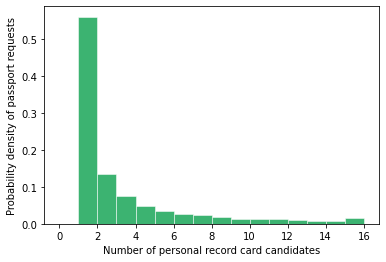

In [63]:
# Create graph with distribution of number of candidates
plt.hist(n_candidates, density=True, range=(0,16), bins=16, color='mediumseagreen', 
         edgecolor='white', linewidth=0.5)
plt.xlabel("Number of personal record card candidates")
plt.ylabel("Probability density of passport requests")
#plt.title("Distribution of number of personal record card candidates per passport request")
plt.show()

## Entity resolution

In [83]:
def name_similarity(name_1, name_2, metric='jaro-winkler'):
    """
    Determine the similarity between two (person or place) names using the given metric.
    For the metric can be chosen between Jaro-Winkler similarity and Levenshtein distance
    
    Parameters
    ----------
    name_1 : string
        String representing the name that needs to be compared with name_2
    name_2 : string
        String representing the name that needs to be compared with name_1
    metric : string (default 'jaro-winkler')
        String representing the metric that needs to be used for determining name similarity.
        Choose one from: ['jaro-winkler', 'levenshtein']
        
    Returns
    -------
    similarity : float
        Number representing the similarity between name_1 and name_2, in the range 0 and 1,
        with higher meaning more similar names
    """
    # Check if a valid name similarity metric is given according to the options of this function
    if metric not in ['jaro-winkler', 'levenshtein']:
        raise ValueError("A valid metric should be given as input, \
        choose from: ['jaro-winkler', 'levenshtein']")
    
    # Check if one or both of the given names are missing values
    # and determine the name similarity value accordingly
    if name_1 is np.nan or name_2 is np.nan:
        # Set similarity to a missing value because it is unknown if names would match 
        similarity = np.nan
    else:
        try:
            # When both names exist, lowercase them first and remove potential 
            # spaces at beginning and end of string to be able to better compare 
            # these standardised versions of the names
            name_1 = name_1.strip().lower()
            name_2 = name_2.strip().lower()

            # Compute the similarity between the standardised names
            if metric == 'jaro-winkler':
                # Compute the Jaro-Winkler similarity between both names with output range 0-1. 
                # This metric focusses on common prefixes
                similarity = jellyfish.jaro_winkler_similarity(name_1, name_2)
            elif metric == 'levenshtein':
                # Compute the Levenshtein similarity between both names and normalize this to 
                # output range 0-1. This metric focusses on number of edits
                # (insertions, deletions and substitutions) required to change one word into 
                # another. The normalization is done because otherwise just the cost of the 
                # number of edits is returned, which depends on the word length and the 
                # cost of each required edit type. This is of course in a different range 
                # than the other similarity values 
                levenshtein_sim = jellyfish.levenshtein_distance(name_1, name_2)
                similarity = 1 - levenshtein_sim / max(len(name_1), len(name_2))
        except UnicodeDecodeError:
            # A UnicodeDecodeError may occur when one of the names has uncommon characters 
            # of which the similarity can't be determined. With creating the blocking key strings,
            # it was determined this only happened 4 times in the entire personal records card 
            # dataset when soundex encoding the names, namely for: ‘t hooft, æde, ‘t hart, 
            # and æbeltje. When this happens, just set the similarity to be missing. 
            # Still, with manual trying of these names this error didn't occur with the 
            # Jaro-Winkler similarity metric (but a slightly lower similarity may be the 
            # result due to a different used symbol like ' instead of ‘)
            similarity = np.nan
    
    return similarity

In [84]:
def partial_missing_date_similarity(date_element_1, date_element_2, time_period=10, 
                                    date_element='day'):
    """
    Determine the fractional time period similarity between given date elements of which 
    one or both dates have partially missing date elements.
    
    When a date is a partially missing value, then it is recorded as a string. 
    This function checks for an element of this string (i.e. day, month, or year) if these parts 
    are missing in one or both of the full date strings, and if not then computes a more 
    gradual similarity value using the fractional time period function with the
    time period (input in years) in this function replaced for the element being 
    a day or month or year element
    
    Parameters
    ----------
    date_element_1 : string
        String representation of (partially missing) date element (i.e. year, month, or day)
        that needs to be compared with date_element_2
    date_element_2 : string
        String representation of (partially missing) date element (i.e. year, month, or day)
        that needs to be compared with date_element_1
    time_period : int (default 10)
        Time period threshold in years (bigger than 0). When the year element difference is 
        larger than or equal to this value, the minimum similarity value of zero will be returned
    date_element : string (default 'day')
        String representing which date element is being compared, choose from:
        ['day', 'month', 'year']
        
    Returns
    -------
    similarity : float
        Number representing the similarity between date_element_1 and date_element_2, 
        in the range 0 and 1, with higher meaning more similar dates
    """
    # Check if a valid time period is given according to this function
    if time_period <= 0:
        raise ValueError("A valid time period should be given as input (bigger than 0)")
    
    # Check if a valid date element is given according to this function
    if date_element not in ['day', 'month', 'year']:
        raise ValueError("A valid date element should be given as input, \
        choose from: ['day', 'month', 'year']")
    
    # Replace time period of day and month based on date_element
    # This is based on how many possibe day and month values there are 
    # so scale the similarity to that 
    # (if larger distance then a non-valid date value was supplied)
    if date_element == 'day':
        time_period = 31
    elif date_element == 'month':
        time_period = 12
        
    # Determine missingness pattern based on date element
    if date_element == 'day' or date_element == 'month':
        missingness_value = '00'
    elif date_element == 'year':
        missingness_value = '0000'
        
    # Determine (gradual) similarity of this date element
    if date_element_1 == missingness_value or date_element_2 == missingness_value:
        # If one or both date elements are missing values (based on the missingness pattern),
        # then no gradual distance is possible to be calculated and hence a missing value is 
        # returned
        similarity = np.nan
    else:
        # Compute a gradual similarity value for the date element, taking into account the
        # corresponding time period threshold. Use try-except clause because if a date part 
        # isn't a string digit, then converting to an integer won't work 
        # (so missing similarity value as result)
        try:
            if abs(int(date_element_1) - int(date_element_2)) >= time_period:
                similarity = 0
            else:
                similarity = 1 - abs(int(date_element_1) - int(date_element_2)) / time_period
        except:
            similarity = np.nan
                            
    return similarity

In [92]:
def date_similarity(date_1, date_2, time_period=10):
    """
    Determine the fractional time period similarity between given dates.
    This will return a similarity value between 0 and 1 with a higher 
    value meaning more similar dates
    
    Parameters
    ----------
    date_1 : string or datetime.date object
        String representation of (partially missing) date that needs to be compared with date_2
    date_2 : string or datetime.date object
        String representation of (partially missing) date that needs to be compared with date_1
    time_period : int (default 10)
        Time period threshold in years (bigger than 0). When the date difference is 
        larger than or equal to this value, the minimum similarity value of zero will be returned

    Returns
    -------
    similarity : float
        Number representing the similarity between date_1 and date_2, 
        in the range 0 and 1, with higher meaning more similar dates
    """
    # Check if a valid time period is given according to this function
    if time_period <= 0:
        raise ValueError("A valid time period should be given as input (bigger than 0)")
        
    # Check if one or both of the given dates are fully or partially missing values or not
    # and determine the date similarity value accordingly
    # Fully missing values are np.nan, partially missing values dash ('-') separated strings 
    # (or when more or less than 8 digits, then just the original recorded string), 
    # and non-missing values are datetime.date objects
    if date_1 is np.nan or date_2 is np.nan:
        # Set similarity to a missing value because this date is fully missing in one or both
        # of the documents so can't be compared
        similarity = np.nan 
    elif isinstance(date_1, str) or isinstance(date_2, str): 
        # Partially missing values are recorded as strings, so need to be checked on similarity
        # If one is a non-missing value so a datetime.date object, then still force it to be 
        # a string as well
        date_1 = str(date_1)
        date_2 = str(date_2)
        
        # If both strings are equal, then a similarity of 1 will be given because these 
        # are recorded similarly in both documents. Else a gradual approach will be tried to
        # be taken instead of directly assigning a similarity value of 0
        if date_1 == date_2:
            # This can also be the case if one or both of the dates didn't include '-' separators 
            # (so no date string separation into year-month-day possible 
            # (i.e. date list length == 1)), which means that less or more than 8 digits
            # were recorded
            similarity = 1 
        else:
            # Split string with '-' separator (format should be YYYY-MM-DD)
            date_1_lst = date_1.split('-')
            date_2_lst = date_2.split('-')

            # If 8 digits were recorded then dates most likely exists of 3 parts 
            # (year, month, day)
            if len(date_1_lst) == 3 and len(date_2_lst) == 3:
                # Check if the supposed years (first element) consist of 4 values and the others 
                # of 2 values, else the formats are unknown/incorrect so can't be gradually 
                # compared and hence get a missing similarity value
                if not(len(date_1_lst[0])==4 and len(date_2_lst[0])==4 and
                       len(date_1_lst[1])==2 and len(date_2_lst[1])==2 and
                       len(date_1_lst[2])==2 and len(date_2_lst[2])==2):
                    similarity = np.nan 
                else:
                    # Check which parts of the date(s) are missing values 
                    # (i.e. filled in with zeroes) and give these dates a (gradual) 
                    # similarity value accordingly 

                    # Compute the fractional time period similarity of day elements
                    day_sim = partial_missing_date_similarity(date_element_1=date_1_lst[2], 
                                                              date_element_2=date_2_lst[2], 
                                                              time_period=time_period, 
                                                              date_element='day')
                    
                    # Compute the fractional time period similarity of month elements
                    month_sim = partial_missing_date_similarity(date_element_1=date_1_lst[1], 
                                                                date_element_2=date_2_lst[1], 
                                                              time_period=time_period, 
                                                              date_element='month')
                    
                    # Compute the fractional time period similarity of year elements
                    year_sim = partial_missing_date_similarity(date_element_1=date_1_lst[0], 
                                                               date_element_2=date_2_lst[0], 
                                                              time_period=time_period, 
                                                              date_element='year')

                    # Combine the similarity values, but if the year similarity is already 0,
                    # then the difference between the dates is already not within the 
                    # time_period range, so the full similarity should be set to 0 
                    if year_sim == 0:
                        similarity = 0
                    else:
                        # Uniformly average the year-month-day element similarities
                        # Missing values are not considered here due to nanmean 
                        # No weighted average is takes because it is unknown what 
                        # are suited ones
                        similarity = np.nanmean([year_sim, month_sim, day_sim])
            else:
                # If not 3 elements are in one or both of the date lists, then it is unknown 
                # what the format is to be able to compare the not fully equal strings 
                # in a more gradual manner. Hence, give a missing similarity value
                similarity = np.nan 
        
    elif isinstance(date_1, datetime.date) or isinstance(date_2, datetime.date):
        # Compute the fractional time period of dates that don't have any (partially) 
        # missing value, so are both datetime.date objects
        if abs(date_1 - date_2).days >= time_period * 365:
            similarity = 0
        else:
            # Subtracting two datetime.date objects gives a datetime.timedelta object,
            # which stores the difference value (but only in days as biggest value so 
            # first convert this timedelta value to years again by dividing by 365 days 
            # in one year)
            similarity = 1 - abs(date_1 - date_2).days / 365 / time_period
    else:
        # If this case is reached, then the format of the dates is fully not as intended, 
        # so getting a missing similarity value and a message
        print("Unknown date format(s) encountered during date similarity between date 1:", 
              date_1, "(type:", type(date_1), 
              "), and date 2:", date_2, "(type:", type(date_2), ")")
        similarity = np.nan
    
    return similarity

In [101]:
def coordinate_similarity(longitude_1, latitude_1, longitude_2, latitude_2, threshold=200000):
    """
    Determine the fractional distance coordinate similarity between 
    given coordinates (longitude-latitude pairs) while taking into 
    account coordinate reference systems that limit distance distortions
    
    The longitude and latitude retrieved using Wikidata are from coordinate location 
    property P625 (see: https://www.wikidata.org/wiki/Property:P625). These, as well 
    as the coordinates retrieved using ErfGeo Proxy (which got these from GeoNames: 
    https://www.geonames.org/about.html), are recorded in the WGS84 coordinate reference
    system (for locations on the Earth, which should here be the case)
    
    Parameters
    ----------
    longitude_1 : float
        Longitude value of the coordinates of place 1 in WGS84 coordinate reference system
    latitude_1 : float
        Latitude value of the coordinates of place 1 in WGS84 coordinate reference system
    longitude_2 : float 
        Longitude value of the coordinates of place 2 in WGS84 coordinate reference system
    latitude_2 : float
        Latitude value of the coordinates of place 2 in WGS84 coordinate reference system
    threshold : int (default 200000)
        Distance threshold in meters (bigger than 0). When the coordinate distance is 
        larger than or equal to this value, the minimum similarity value of zero will be returned
    
    Returns
    -------
    similarity : float
        Number representing the similarity between given coordinates (longitude-latitude pairs), 
        in the range 0 and 1, with higher meaning more similar coordinates    
    """       
    # Check if any of the coordinate values is missing, and else calculate a gradual
    # similarity value
    if longitude_1 is np.nan or latitude_1 is np.nan or longitude_2 is np.nan or latitude_2 is np.nan:
        # No coordinate comparison can be made when one of the coordinate elements is a 
        # missing value, so then set coordinate similarity to be missing as well
        similarity = np.nan 
    else:             
        # Specify output CRS projection for when two places are both in the Netherlands or 
        # Indonesia (otherwise stays the input CRS WGS84)
        # Do this by checking if the WGS84 lon-lat pair is between the WGS84 boundaries 
        # of the Netherlands (the if-statement) or Indonesia (the elif statement) to know 
        # if the CRS can be reprojected for better distance calculation 
        # (less distance distortions then). Then also create boolean stating if a reprojection
        # is required
        reproject = False
        if 3.2 <= longitude_1 <= 7.22 and 50.75 <= latitude_1 <= 53.7 and \
            3.2 <= longitude_2 <= 7.22 and 50.75 <= latitude_2 <= 53.7:
            output_projection = 'epsg:28992' # For two places in the Netherlands
            reproject = True
        elif 92.01 <= longitude_1 <= 141.46 and -13.95 <= latitude_1 <= 7.79 and \
            92.01 <= longitude_2 <= 141.46 and -13.95 <= latitude_2 <= 7.79:
            output_projection = 'epsg:4897' # For two places in Indonesia
            reproject = True
        
        # If needed, convert coordinate pairs to correct Coordinate Reference System (CRS) 
        # such that distance distortions are minimized, and calculate distance between
        # coordinates
        if reproject:
            # Specify the input CRS projection
            input_projection = 'epsg:4326' # WGS84 lon-lat for two places 
                # in different countries or unknown where one or both are
            
            # Specify required CRS transformation
            transformer = Transformer.from_crs(input_projection, output_projection, 
                                               always_xy=True)
            
            # Transform lon-lat pairs from WGS84 to Indonesian or Dutch CRS
            longitude_1, latitude_1 = transformer.transform(longitude_1, latitude_1)
            longitude_2, latitude_2 = transformer.transform(longitude_2, latitude_2)
            
            # Determine Euclidean distance between coordinates, which gives result in meters
            dist = distance.euclidean([longitude_1, latitude_1], [longitude_2, latitude_2]) 
            
        else:
            # Use Haversine distance to determine distance between coordinates
            # because WGS84 is lon-lat on spheroid
            dist = haversine((latitude_1, longitude_1), (latitude_2, longitude_2), 
                             unit=Unit.METERS) 
        
        # If distance is larger than or equal to given threshold, then set similarity to 0
        if dist >= threshold:
            similarity = 0
        else:
            # Determine gradual similarity value fractional to threshold, with result 
            # in range 0-1
            similarity = 1 - dist / threshold
        
        return similarity 

In [103]:
def write_chunk(i, results, csv_path):
    """
    Intermediately write results to .csv file
    
    Function equal to the one in Location_matching_with_ErfGeo_Proxy.ipybn

    Parameters
    ----------    
    i : int
        The ith place that was run, required to check if
        a header should still be written (only the first iteration)
    results : list with dictionaries
        List with dictionaries containing the results
    csv_path : str
        Path to .csv file where to write outputs in
    """
    # Only write header in the first iteration
    if i == 0:
        header = True 
    else:
        header = False
        
    # Create Pandas Dataframe from results list with dictionaries    
    chunk = pd.DataFrame(results)    
    
    # Save chunk to .csv file (mode 'a' is appending)
    chunk.to_csv(csv_path, header=header, mode='a', sep=',', index=False) 

In [243]:
def entity_resolution(df_passport, df_person_card, csv_path, place_enriched=False, N=100):
    """
    Perform entity resolution between passport requests and personal record cards where 
    passport requests are compared with personal record cards with the same blocking key string.
    If the data is enriched with place information from LOD sources, then a more gradual place
    similarity can be determined
    
    Parameters
    ----------
    df_passport : Pandas dataframe
        Data set with passport requests that will be compared to their personal record card
        candidates
    df_person_card : Pandas dataframe
        Data set with personal record cards that will be compared to passport requests
    csv_path : str
        Path to .csv file where to write outputs in    
    place_enriched : bool (default False)
        Boolean stating if the datasets are enriched with place data, 
        meaning these among others contain a Wikidata and GeoNames URI feature
    N : int (default 100)
        Integer stating how often intermediate results need to be written to .csv file.
        This is respective to the number of passport requests, so always the results of all
        similarity calculations with candidate personal record cards of a passport request 
        will be saved
    """
    # Reset indices of dataframes as .iterrows() will otherwise just give the ones that are
    # recorded within the dataset instead of relative to the number of records that are 
    # processed
    df_passport.reset_index(inplace=True)
    df_person_card.reset_index(inplace=True)
    
    results = []
    # Loop through passport requests and compute the similarity with all of its
    # candidate personal record cards
    for i, passport_request in tqdm(df_passport.iterrows(), total=len(df_passport), 
                                    desc='Passport requests', position=0):
        # Retrieve the candidate personal record cards, 
        # which are the ones with the same blocking key string as this passport request
        candidate_person_cards = df_person_card[
            df_person_card.Blocking_key.values == passport_request.Blocking_key] 
        
        # Get passport id to use for saved results
        passport_id = passport_request.id
        
        # Loop through candidate personal record cards (same blocking key as passport request)
        for j, candidate in tqdm(candidate_person_cards.iterrows(),
                                 total=len(candidate_person_cards), 
                             desc='Candidates', position=0):
            
            # Perform name similarity on first names
            first_name_sim = name_similarity(name_1=passport_request.Voornaam, 
                                             name_2=candidate.Voornaam,
                                            metric='jaro-winkler')
            
            # Perform name similarity on last names
            last_name_sim = name_similarity(name_1=passport_request.Achternaam, 
                                            name_2=candidate.Achternaam,
                                           metric='jaro-winkler')
            
            # Average name similarities to 1 value (disregarding missing values)
            avg_name_sim = np.nanmean([first_name_sim, last_name_sim])

            # Perform birth date similarity with a date difference and scaling threshold 
            # of 10 years (both are birth dates so no larger threshold needed)
            birth_date_sim = date_similarity(date_1=passport_request.Geboortedatum, 
                                             date_2=candidate.Geboortedatum, 
                                             time_period=10) 
            
            # First check if records were enriched with place information from 
            # Wikidata/ErfGeo Proxy. If not, then follow the standard procedure with 
            # only comparing place strings (often only place name recorded in that case), else
            # check also values in additional columns for similarities 
            # (i.e. coordinates and URIs)
            if not place_enriched:
                # Firstly, compare recorded place names using Levenshtein distance
                place_name_sim = name_similarity(name_1=passport_request.Geboorteplaats, 
                                                     name_2=candidate.Geboorteplaats, 
                                                 metric='levenshtein')
                
                # Secondly, compare recorded country names using Levenshtein distance
                country_name_sim = name_similarity(name_1=passport_request.Geboorteland, 
                                                 name_2=candidate.Geboorteland, 
                                                   metric='levenshtein')

                # Thirdly, compare recorded province names using Levenshtein distance
                province_name_sim = name_similarity(name_1=passport_request.Geboorteprovincie, 
                                                 name_2=candidate.Geboorteprovincie, 
                                                    metric='levenshtein')
                
                # Give coordinate similarity a missing value as no lon-lat pair recorded 
                # on documents (only after enrichment with LOD entity)
                coordinate_sim = np.nan
                
                # Average place similarities (disregarding missing values)
                avg_place_sim = np.nanmean([place_name_sim, country_name_sim, province_name_sim, 
                                             coordinate_sim])
            else:
                # Check if Wikidata and/or GeoNames URI match (if so then directly average place 
                # similarity = 1 because equivalent place entities are identified)
                # Note that np.nan == np.nan returns False, so both need to have an equal 
                # URI to pass this statement
                if passport_request.wikidata_uri == candidate.wikidata_uri or \
                   passport_request.geonames_uri == candidate.geonames_uri:
                    # Set the place feature similarities to missing values because these
                    # did not have to be calculated
                    avg_place_sim = 1
                    place_name_sim = np.nan
                    country_name_sim = np.nan
                    province_name_sim = np.nan
                    coordinate_sim = np.nan
                else:
                    # URIs don't match (so different place entities) or both places did not 
                    # resolve to a unique one entity using Wikidata or ErfGeo Proxy queries 
                    # (i.e. have missing values)
                    # In this case make a more gradual similarity which takes into account 
                    # the additional information retrieved from LOD datasets 
                    # (if it got resolved to a URI), such as additional country indicators
                    # and/or coordinates
                    
                    # Firstly, compare (retrieved standardised versions of) place names 
                    # using Levenshtein distance
                    place_name_sim = name_similarity(name_1=passport_request.Geboorteplaats, 
                                                     name_2=candidate.Geboorteplaats, 
                                                     metric='levenshtein')
                    
                    # Secondly, compare (retrieved) country names using Levenshtein distance
                    # Directly assign similarity 1 if country URI is equal already 
                    # (equivalent country then)
                    if passport_request.country_wikidata_uri == candidate.country_wikidata_uri:
                        country_name_sim = 1
                    else:
                        country_name_sim = name_similarity(name_1=passport_request.Geboorteland, 
                                                           name_2=candidate.Geboorteland, 
                                                           metric='levenshtein')
                    
                    # Thirdly, compare recorded province names using Levenshtein distance
                    province_name_sim = name_similarity(name_1=passport_request.Geboorteprovincie, 
                                                     name_2=candidate.Geboorteprovincie, 
                                                        metric='levenshtein')
                    
                    # Lastly, determine fractional coordinate distance between retrieved 
                    # longitude-latitude pairs while taking into account CRS projections that
                    # limit distance distortions
                    coordinate_sim = coordinate_similarity(longitude_1=passport_request.longitude, 
                                                           latitude_1=passport_request.latitude, 
                                                           longitude_2=candidate.longitude, 
                                                           latitude_2=candidate.latitude, 
                                                           threshold=200000) 
                    

                    # Average place similarities (disregarding missing values)
                    avg_place_sim = np.nanmean([place_name_sim, country_name_sim, 
                                                province_name_sim, coordinate_sim])
            
            # Average content similarities to 1 value (disregarding missing values)
            avg_similarity = np.nanmean([avg_name_sim, birth_date_sim, avg_place_sim])
            
            # Save all feature and average similarity values in a dictionary within the results
            # list. Here also add identifiers of the passport request and personal record card,
            # such that more information about these can be looked up 
            results.append({"passport_id":passport_id, "person_card_id":candidate.id,
                            "first_name_sim":first_name_sim, "last_name_sim":last_name_sim,
                            "avg_name_sim":avg_name_sim, "birth_date_sim":birth_date_sim,
                            "place_name_sim":place_name_sim, "country_name_sim":country_name_sim,
                            "province_name_sim":province_name_sim, 
                            "coordinate_sim":coordinate_sim,
                            "avg_place_sim":avg_place_sim, "avg_similarity":avg_similarity})
        
        # Check if results need to be (intermediately) saved
        if i % N == 0:
            # Intermediately save queried results
            write_chunk(i=i, results=results, csv_path=csv_path)
            results = []
        elif i == len(df_passport) - 1:
            # Write last results
            write_chunk(i=i, results=results, csv_path=csv_path)

In [5]:
# Specify paths to save results in
# Path to results without enriched place data 
results_path = os.path.join(data_path, "results.csv")

# Path to results with enriched place data 
results_enriched_path = os.path.join(data_path, "results_enriched_places.csv")

In [255]:
# Run entity resolution on non-place enriched data
entity_resolution(df_passport=df_passport_subset,
                  df_person_card=df_person_card_subset, 
                  csv_path=results_path,
                  place_enriched=False, N=100)

Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 800.13it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1249.72it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.33it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1557.61it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 1793.98it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.91it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1400.50it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2003.97it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 2437.84it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.73it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.17it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.99it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1005.83it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 874.78it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1500.65it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.22it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2000.38it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.85it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1499.74it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1750.96it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.68it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.93it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1888.96it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.43it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.56it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.68it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1001.62it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1005.35it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1153.95it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1199.11it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 800.90it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1833.54it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.61it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.52it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1999.67it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1750.23it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1895.18it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.17it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.68it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.14it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1250.76it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.89it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.07it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.32it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1600.96it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.46it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2002.05it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.45it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.83it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1714.64it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1006.19it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1000.55it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1008.25it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1496.90it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.17it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1199.80it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.61it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.31it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.16it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.67it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1000.19it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 999.30it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.44it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 1941.51it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1333.48it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1727.85it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1001.27it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1000.67it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1499.93it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 800.86it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1401.24it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.84it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


Passport requests: 100%|█████████████████████████████████████████████████████████| 13730/13730 [04:28<00:00, 51.08it/s]


In [256]:
# Run entity resolution on place enriched data
entity_resolution(df_passport=df_passport_enriched_subset, 
                  df_person_card=df_person_card_enriched_subset, 
                  csv_path=results_enriched_path,
                  place_enriched=True, N=100)

Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.48it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.70it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 56.36it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 2381.46it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 90.92it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 52.24it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.71it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 237/237 [00:03<00:00, 69.27it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.39it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 50.49it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 752.88it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 63.62it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1399.85it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1400.84it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 992.50it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1214.36it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.41it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.46it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.45it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1071.34it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.68it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.08it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 142.85it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 77.34it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.90it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.01it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.67it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.71it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 62.89it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.44it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1522.03it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.39it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 83.33it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1250.02it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.87it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 78.60it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.98it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1331.95it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.80it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.94it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.55it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1329.17it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.51it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1500.65it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.91it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.71it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 46.51it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


Candidates: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.39it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 56.60it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.39it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 52.17it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.56it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.65it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1499.39it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 665.45it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.62it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 62.49it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1333.32it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 69.40it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.46it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 53.35it/s]


Candidates: 100%|██████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 59.33it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.41it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.68it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.93it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.14it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 50.63it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.47it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 48.15it/s]


Candidates: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]


Candidates: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Passport requests: 100%|█████████████████████████████████████████████████████████| 13730/13730 [22:28<00:00, 10.18it/s]


## Inspect results of entity resolution and determine candidate links

In [ ]:
# Load all saved results (non-place ennriched) into a pandas dataframe
df_results = pd.read_csv(results_path, sep=",", header=0, index_col=None)

# Inspect dataframe
# Outputs cleared due to this being able to be linked to privacy-sensitive data
df_results.head(10)

In [ ]:
# Load all saved results (place ennriched) into a pandas dataframe
df_results_enriched = pd.read_csv(results_enriched_path, sep=",", header=0, index_col=None)

# Inspect dataframe
# Outputs cleared due to this being able to be linked to privacy-sensitive data
df_results_enriched.head(10)

In [64]:
# Inspect statistics of non-place enriched results
df_results.describe()

passport_id  first_name_sim  last_name_sim   avg_name_sim  \
count  124859.000000   124798.000000  124859.000000  124859.000000   
mean    53168.673311        0.966669       0.956139       0.961407   
std     47031.383319        0.061595       0.067355       0.049556   
min         8.000000        0.562708       0.549708       0.647367   
25%     11013.000000        0.933333       0.912500       0.933492   
50%     31192.000000        1.000000       1.000000       0.988562   
75%     99133.000000        1.000000       1.000000       1.000000   
max    141384.000000        1.000000       1.000000       1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count   124835.000000   124859.000000      17826.000000        1491.000000   
mean         0.173124        0.215067          0.787819           0.477344   
std          0.311266        0.236593          0.323034           0.361658   
min          0.000000        0.000000          0.000000           0.000000   
25%          0.000000        0.100000          0.300000           0.153846   
50%          0.000000        0.153846          1.000000           0.384615   
75%          0.323118        0.230769          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0  124859.000000   124859.000000  
mean              NaN       0.257878        0.464165  
std               NaN       0.255120        0.155209  
min               NaN       0.000000        0.222515  
25%               NaN       0.111111        0.362464  
50%               NaN       0.181818        0.400779  
75%               NaN       0.300000        0.536738  
max               NaN       1.000000        1.000000

In [68]:
# Inspect number of missing values of non-place enriched results
df_results.isna().sum()

passport_id               0
person_card_id            0
first_name_sim           61
last_name_sim             0
avg_name_sim              0
birth_date_sim           24
place_name_sim            0
country_name_sim     107033
province_name_sim    123368
coordinate_sim       124859
avg_place_sim             0
avg_similarity            0
dtype: int64

In [65]:
# Inspect statistics of place enriched results
df_results_enriched.describe()

passport_id  first_name_sim  last_name_sim   avg_name_sim  \
count  124859.000000   124798.000000  124859.000000  124859.000000   
mean    53168.673311        0.966669       0.956139       0.961407   
std     47031.383319        0.061595       0.067355       0.049556   
min         8.000000        0.562708       0.549708       0.647367   
25%     11013.000000        0.933333       0.912500       0.933492   
50%     31192.000000        1.000000       1.000000       0.988562   
75%     99133.000000        1.000000       1.000000       1.000000   
max    141384.000000        1.000000       1.000000       1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count   124835.000000   105605.000000      63411.000000        1278.000000   
mean         0.173124        0.164579          0.913298           0.444198   
std          0.311266        0.125980          0.240379           0.349615   
min          0.000000        0.000000          0.000000           0.000000   
25%          0.000000        0.100000          1.000000           0.153846   
50%          0.000000        0.142857          1.000000           0.384615   
75%          0.323118        0.222222          1.000000           0.692308   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count    57857.000000  124859.000000   124859.000000  
mean         0.601522       0.507576        0.547404  
std          0.279072       0.298831        0.157704  
min          0.000000       0.000000        0.223362  
25%          0.447994       0.230659        0.438367  
50%          0.677694       0.549528        0.523033  
75%          0.819641       0.668358        0.644318  
max          1.000000       1.000000        1.000000

In [69]:
# Inspect number of missing values of place enriched results
# Here missing place values can also occur due to directly 
# being able to assign avg_place_sim = 1 when URIs match
df_results_enriched.isna().sum()

passport_id               0
person_card_id            0
first_name_sim           61
last_name_sim             0
avg_name_sim              0
birth_date_sim           24
place_name_sim        19254
country_name_sim      61448
province_name_sim    123581
coordinate_sim        67002
avg_place_sim             0
avg_similarity            0
dtype: int64

In [43]:
# Consider the personal record card candidate the link for a passport request when it has the
# highest average similarity with the corresponding passport request from all other candidates 
df_results_subset = df_results[
    df_results.avg_similarity == 
    df_results.groupby(['passport_id'])['avg_similarity'].transform(max)]

In [44]:
df_results_enriched_subset = df_results_enriched[
    df_results_enriched.avg_similarity == 
    df_results_enriched.groupby(['passport_id'])['avg_similarity'].transform(max)]

In [ ]:
# Inspect the candidate links (passport requests with np.nan avg_similarity for all candidates
# are not included here because no actual link could be made)
# Outputs cleared due to this being able to be linked to privacy-sensitive data
df_results_subset.head()

In [ ]:
df_results_enriched_subset.head()

In [263]:
# Check how many records have a candidate link (instead of the average similarity value
# with all their candidates being np.nan)
print("The number of candidate links without place enrichment is:", len(df_results_subset))

The number of candidate matches without place enrichment is: 14172


In [66]:
print("The number of unique passport requests that received at least one candidate link is:", 
      df_results_subset.passport_id.nunique())

The number of unique passport requests that received at least one candidate match is: 13730


In [264]:
print("The number of candidate links with place enrichment is:", 
      len(df_results_enriched_subset))

The number of candidate matches with place enrichment is: 14444


In [67]:
print("The number of unique passport requests that received at least one candidate link is:", 
      df_results_enriched_subset.passport_id.nunique())

The number of unique passport requests that received at least one candidate match is: 13730


In [265]:
# Inspect candidate links statistics
df_results_subset.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count   14172.000000    14128.000000   14172.000000  14172.000000   
mean    65192.378987        0.969416       0.978345      0.973898   
std     47499.993892        0.059324       0.049632      0.042093   
min         8.000000        0.570988       0.583041      0.668362   
25%     21434.750000        0.967921       1.000000      0.951197   
50%     50595.500000        1.000000       1.000000      1.000000   
75%    115332.250000        1.000000       1.000000      1.000000   
max    141384.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count    14163.000000    14172.000000        1495.00000         182.000000   
mean         0.553151        0.539687           0.79758           0.748211   
std          0.430160        0.407685           0.31578           0.358495   
min          0.000000        0.000000           0.00000           0.000000   
25%          0.000000        0.157895           0.47619           0.416667   
50%          0.689606        0.333333           1.00000           1.000000   
75%          1.000000        1.000000           1.00000           1.000000   
max          1.000000        1.000000           1.00000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0   14172.000000    14172.000000  
mean              NaN       0.563337        0.696840  
std               NaN       0.394472        0.241460  
min               NaN       0.000000        0.247992  
25%               NaN       0.187500        0.481481  
50%               NaN       0.500000        0.666667  
75%               NaN       1.000000        1.000000  
max               NaN       1.000000        1.000000

In [266]:
df_results_enriched_subset.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count   14444.000000    14397.000000   14444.000000  14444.000000   
mean    65115.175159        0.969957       0.978413      0.974203   
std     47534.968459        0.058632       0.049598      0.041799   
min         8.000000        0.570988       0.583041      0.668362   
25%     21112.500000        0.970833       1.000000      0.951828   
50%     50481.000000        1.000000       1.000000      1.000000   
75%    115331.250000        1.000000       1.000000      1.000000   
max    141384.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count    14435.000000     6595.000000       3974.000000          89.000000   
mean         0.537217        0.208166          0.911992           0.679574   
std          0.434978        0.174830          0.249206           0.355920   
min          0.000000        0.000000          0.000000           0.000000   
25%          0.000000        0.111111          1.000000           0.333333   
50%          0.667742        0.179487          1.000000           0.692308   
75%          1.000000        0.250000          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count     3895.000000   14444.000000    14444.000000  
mean         0.664091       0.756398        0.756007  
std          0.283969       0.312280        0.211156  
min          0.000000       0.000000        0.261932  
25%          0.546288       0.566759        0.594980  
50%          0.732963       1.000000        0.749006  
75%          0.889671       1.000000        1.000000  
max          1.000000       1.000000        1.000000

In [6]:
# Specify paths to save candidate links of results in
# Path to candidate links without enriched place data 
matches_path = os.path.join(data_path, "matches.csv")

# Path to candidate links with enriched place data 
matches_enriched_path = os.path.join(data_path, "matches_enriched_places.csv")

In [268]:
# Save the subset of candidate links 
df_results_subset.to_csv(matches_path, header=True, sep=',', index=False)
df_results_enriched_subset.to_csv(matches_enriched_path, header=True, sep=',', index=False)

In [21]:
# Load candidate links again in new session
df_results_subset = pd.read_csv(matches_path, sep=",", header=0, index_col=None)
df_results_enriched_subset = pd.read_csv(matches_enriched_path, sep=",", header=0, index_col=None)

In [4]:
# Load cleaned personal record cards data into a dataframe to be able to attach 
# CBG document number to personal record card data (requested by CBG for validation)
df_person_card = pd.read_csv(person_card_path, sep=",", header=0, index_col=None)

In [460]:
# Inspect how many candidate links were found 
# Note that some passport requests got multiple candidate links assigned due to them having
# the same maximum value
print(len(df_results_subset), "candidate links were found for", 
      len(df_results.passport_id.unique()), 
      "passport requests in the non-place-enriched data, among", 
      len(df_results), "candidates")

print(len(df_results_enriched_subset), "candidate links were found for", 
      len(df_results_enriched.passport_id.unique()), 
      "passport requests in the place-enriched data, among", 
      len(df_results_enriched), "candidates")

14172 candidate matches were found for 13730 passport requests in the non-place-enriched data, among 124859 candidates
14444 candidate matches were found for 13730 passport requests in the place-enriched data, among 124859 candidates


In [474]:
# Check how many equal candidate links between the non- and place enriched data runs
# (as being both candidate link, which is of course easy when there
# was just 1 candidate in the first place, as was the case for around 60% of passport requests)
results_id_set = set([(passport_id, person_card_id) for i, (passport_id, person_card_id) \
                      in df_results_subset[['passport_id', 'person_card_id']].iterrows()])
results_enriched_id_set = set([(passport_id, person_card_id) \
                               for i, (passport_id, person_card_id) \
                               in df_results_enriched_subset[[
    'passport_id', 'person_card_id']].iterrows()])

print("There are", len(results_id_set.intersection(results_enriched_id_set)), 
      "intersecting candidate links among the non- and place-enriched datasets")
print("There are", len(results_id_set.union(results_enriched_id_set)), 
      "union candidate links among the non- and place-enriched datasets")

There are 12236 intersecting candidate matches among the non- and place-enriched datasets
There are 16380 union candidate matches among the non- and place-enriched datasets


In [169]:
def display_histograms(df, df_enriched, column, xlabel, ylabel, density=True):
    """
    Create a histogram that displays the proportion/number of candidate (links)
    that fall within certain similarity value bins for both non- and place enriched
    data results
    
    Parameters
    ----------
    df : Pandas dataframe
        Dataframe containing the similarity value results of non-place enriched data
    df_enriched : Pandas dataframe
        Dataframe containing the similarity value results of place enriched data
    column : string
        Title of the column with similarity values that are used for displaying the histogram
    xlabel : string
        String with x-axis label of the histogram
    ylabel : string
        String with y-axis label of the histogram
    density : boolean (default True)
        Boolean stating if the y-axis of the histogram shows probability densities of the 
        similarity values or absolute numbers
    """
    # Create histogram
    plt.hist([df_enriched[column], df[column]], 
             density=density, range=(0,1), bins=20, stacked=True, 
             color=['mediumseagreen', 'cornflowerblue'], edgecolor='white', linewidth=0.5)
    
    # Add axis labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend
    plt.legend(title='Place enrichment', labels=['True', 'False'])
    
    # Display histogram
    plt.show()

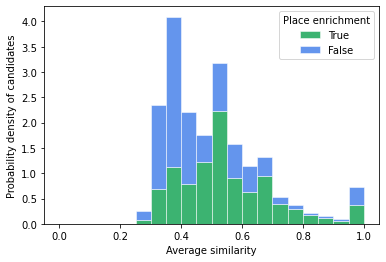

In [171]:
# Distribution of average similarity for all candidates
display_histograms(df=df_results, df_enriched=df_results_enriched, 
                   column='avg_similarity', xlabel="Average similarity",
                  ylabel = "Probability density of candidates", density=True)

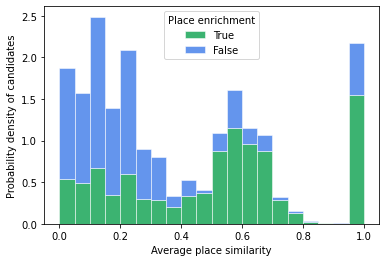

In [41]:
# Distribution of average place similarity for all candidates
display_histograms(df=df_results, df_enriched=df_results_enriched, 
                   column='avg_place_sim', xlabel="Average place similarity",
                  ylabel="Probability density of candidates")

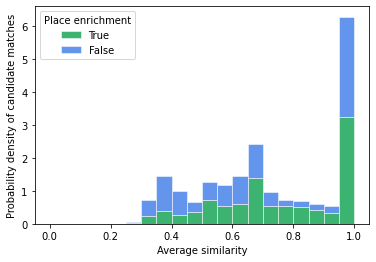

In [46]:
# Distribution of average similarity for candidate links (the candidate with highest 
# mean similarity)
display_histograms(df=df_results_subset, df_enriched=df_results_enriched_subset, 
                   column='avg_similarity', xlabel="Average similarity",
                  ylabel="Probability density of candidate links")

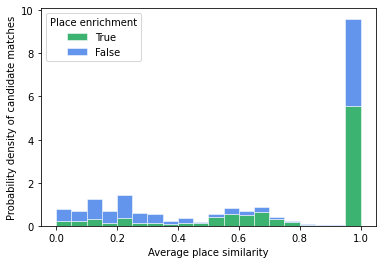

In [45]:
# Distribution of average place similarity for candidate links (the candidate with highest 
# mean similarity)
display_histograms(df=df_results_subset, df_enriched=df_results_enriched_subset, 
                   column='avg_place_sim', xlabel="Average place similarity",
                  ylabel="Probability density of candidate links")

In [49]:
# Determine the difference between similarity scores of non- and place enriched record ER runs
# Higher values mean that place enrichment increased the similarity score, else decreased
df_results_difference = df_results_enriched.loc[
    :,~df_results_enriched.columns.isin(['passport_id', 'person_card_id'])] \
        - df_results.loc[:,~df_results.columns.isin(['passport_id', 'person_card_id'])]
df_results_difference['passport_id'] = df_results_enriched['passport_id']
df_results_difference['person_card_id'] = df_results_enriched['person_card_id']

In [454]:
# Inspect statistics of differences
df_results_difference.describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count        124798.0       124859.0      124859.0        124835.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count   105605.000000      15818.000000             1278.0             0.0   
mean        -0.000043          0.025642                0.0             NaN   
std          0.013842          0.131882                0.0             NaN   
min         -0.699248         -0.900000                0.0             NaN   
25%          0.000000          0.000000                0.0             NaN   
50%          0.000000          0.000000                0.0             NaN   
75%          0.000000          0.000000                0.0             NaN   
max          0.284091          0.903226                0.0             NaN   

       avg_place_sim  avg_similarity    passport_id  
count  124859.000000   124859.000000  124859.000000  
mean        0.249698        0.083239   53168.673311  
std         0.281905        0.093979   47031.383319  
min        -0.722640       -0.240880       8.000000  
25%         0.000000        0.000000   11013.000000  
50%         0.173254        0.057751   31192.000000  
75%         0.448114        0.149389   99133.000000  
max         1.000000        0.454545  141384.000000

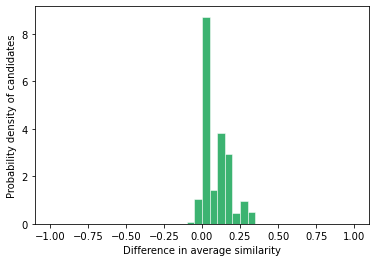

In [50]:
# Plot histogram with difference in average similarity (positive is increase when place enriched)
plt.hist(df_results_difference['avg_similarity'], 
             density=True, range=(-1,1), bins=40, stacked=True, 
             color='mediumseagreen', edgecolor='white', linewidth=0.5)
plt.xlabel("Difference in average similarity")
plt.ylabel("Probability density of candidates")
plt.show()

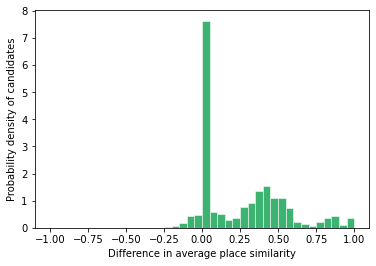

In [51]:
# Plot difference in average place similarity (positive is increase when place enriched)
# Note that if place names already matched well, then there is little to improve on 
# (already a high score so difference around 0)
# So the big improvements are when additional information could directly equal URIs
# (for different place name variants) or replaced some strings with standardised name variants
plt.hist(df_results_difference['avg_place_sim'], 
             density=True, range=(-1,1), bins=40, stacked=True, 
             color='mediumseagreen', edgecolor='white', linewidth=0.5)
plt.xlabel("Difference in average place similarity")
plt.ylabel("Probability density of candidates")
plt.show()

## Validation

In [37]:
# Check for outliers with Z-test
# Non-place enriched data
abs_z_scores = abs(stats.zscore(df_results.loc[
    :,~df_results.columns.isin(['passport_id', 'person_card_id'])]))
df_results_outliers = df_results[(abs_z_scores >= 3).any(axis=1)] 

In [38]:
# Outliers exist
len(df_results_outliers)

10671

In [35]:
# Check for outliers with Z-test
# Place enriched data
abs_z_scores_enriched = abs(stats.zscore(df_results_enriched.loc[
    :,~df_results_enriched.columns.isin(['passport_id', 'person_card_id'])]))
df_results_enriched_outliers = df_results_enriched[(abs_z_scores_enriched >= 3).any(axis=1)]

In [36]:
# Outliers exist
len(df_results_enriched_outliers)

2786

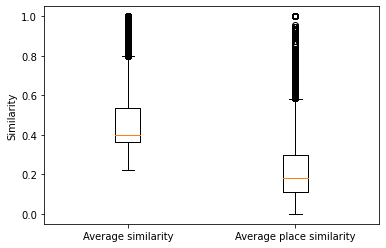

In [13]:
# Visual check for outliers with boxplot (no points should be outside of the box or whiskers)
plt.boxplot([df_results['avg_similarity'], df_results['avg_place_sim']], 
            labels=["Average similarity", "Average place similarity"])
plt.ylabel("Similarity")
plt.show()

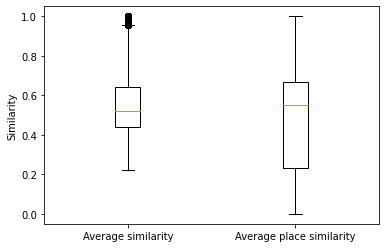

In [14]:
plt.boxplot([df_results_enriched['avg_similarity'], df_results_enriched['avg_place_sim']], labels=["Average similarity", "Average place similarity"])
plt.ylabel("Similarity")
plt.show()

In [17]:
# Check for normal distribution
# (t-test assumes that the data comes from a normal distribution so shouldn't display 
# significant outliers w.r.t. that). If normally distributed then can do paired t-test 
# (we test same candidates before and after changes in place similarity calculation), 
# else do Wilcoxon signed-rank Test that is similar but doesn't have that assumption
# Results make sense as there are many values at same similarity
stats.shapiro(df_results_enriched['avg_similarity'])

C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9343891143798828, pvalue=0.0)

In [18]:
stats.shapiro(df_results['avg_similarity'])

ShapiroResult(statistic=0.8117605447769165, pvalue=0.0)

In [19]:
stats.shapiro(df_results_enriched['avg_place_sim'])

ShapiroResult(statistic=0.9376406073570251, pvalue=0.0)

In [20]:
stats.shapiro(df_results['avg_place_sim'])

ShapiroResult(statistic=0.7952156662940979, pvalue=0.0)

In [23]:
# Paired t-test (if normally distributed which is here not the case so invalid result) 
# Read about this at: 
# https://pythonfordatascienceorg.wordpress.com/paired-samples-t-test-python/#what-is-it
stats.ttest_rel(df_results['avg_similarity'], df_results_enriched['avg_similarity'])

Ttest_relResult(statistic=-312.971536144109, pvalue=0.0)

In [24]:
stats.ttest_rel(df_results['avg_place_sim'], df_results_enriched['avg_place_sim'])

Ttest_relResult(statistic=-312.9838725852677, pvalue=0.0)

In [27]:
# Wilcoxon signed-rank Test (if not normally distributed or outliers, which is here the case)
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(df_results['avg_similarity'], 
                                             df_results_enriched['avg_similarity'])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 61541503.0 with p-value 0.0


In [28]:
wilcoxon_avg_place_sim, p_avg_place_sim = stats.wilcoxon(df_results['avg_place_sim'], 
                                                         df_results_enriched['avg_place_sim'])
print("Wilcoxon signed-rank test value", wilcoxon_avg_place_sim, "with p-value", p_avg_place_sim)

Wilcoxon signed-rank test value 61545811.5 with p-value 0.0


In [30]:
# Cut the average similarity values into bins, which are the strata that get each a proportional
# number of samples in the stratified random sample
df_results_enriched_subset['avg_sim_cat'] = pd.cut(
    df_results_enriched_subset['avg_similarity'], 
    bins=[0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Inspect resulting strata
# Outputs cleared due to this being able to be linked to privacy-sensitive data
df_results_enriched_subset.head(10)

In [22]:
# Subset the (place enriched) candidate links to only remain ones that are more likely an 
# actual link by being closer to a potential threshold value. Sometimes this was lowered 
# a bit more to have a more distributed average similarity than only very high scores
# avg_name_sim mean is 0.97 +/- 0.04 so 0.90 (lower than 25% IQR) can be expected as 
# minimum person name value of links (so 0.30 minimum average similarity only based on this)
# Birth date similarity mean 0.54 +/- 0.43 and 50% IQR 0.67. Value of 0.5 means 5 years between
# birth dates (so 0.17 minimum average similarity only based on this)
# Average place similarity mean 0.76 +/- 0.31 with 25% IQR 0.57 and 50% IQR already 1.0
# 0.5 coordinate sim value is 100km distance, string similarities should be quite equal
# to be the same place (especially the more standardised country and province names).
# Most got avg value 1.0 directly due to URI match so ones with lower values are already
# more likely non-equivalent places.
df_results_enriched_subset = df_results_enriched_subset[
    (df_results_enriched_subset.avg_name_sim >= 0.90) & 
    (df_results_enriched_subset.birth_date_sim >= 0.5) & 
    (df_results_enriched_subset.avg_place_sim >= 0.5)]

In [23]:
# Inspect the statistics of subsetted place enriched results
df_results_enriched_subset.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count    7270.000000     7247.000000    7270.000000   7270.000000   
mean    63694.493122        0.986949       0.989228      0.988104   
std     47588.819277        0.035075       0.031959      0.023669   
min         8.000000        0.802924       0.805556      0.900330   
25%     20270.250000        1.000000       1.000000      0.992857   
50%     47351.000000        1.000000       1.000000      1.000000   
75%    114901.500000        1.000000       1.000000      1.000000   
max    141366.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count     7270.000000     1767.000000       1516.000000          42.000000   
mean         0.896433        0.254506          0.996489           0.769383   
std          0.152438        0.231865          0.052728           0.270777   
min          0.500000        0.000000          0.100000           0.153846   
25%          0.784409        0.111111          1.000000           0.615385   
50%          1.000000        0.200000          1.000000           1.000000   
75%          1.000000        0.307692          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count     1346.000000    7270.000000     7270.000000  
mean         0.768305       0.915591        0.933376  
std          0.167770       0.158108        0.095170  
min          0.000000       0.500000        0.650107  
25%          0.671134       1.000000        0.864665  
50%          0.790978       1.000000        1.000000  
75%          0.906812       1.000000        1.000000  
max          1.000000       1.000000        1.000000

In [24]:
print("Number of remaining candidate links:", len(df_results_enriched_subset))

Number of remaining candidate matches: 7270


In [54]:
# Create a stratified (on average similarity values that are binned into 10 equiwidth bins) 
# random split of the candidate links that will be manually validated by domain experts of CBG
# This will be 100 matches from the place enriched matches
split = StratifiedShuffleSplit(n_splits=1, test_size=100, random_state=42)
validation_idx = list(split.split(
    df_results_enriched_subset.loc[:, df_results_enriched_subset.columns != 'avg_sim_cat'], 
    df_results_enriched_subset['avg_sim_cat']))

In [55]:
# Create a validation set using the indices of the selected stratified samples
# Make sure to reset the indices of the dataframe because the validation_idx has indices
# with respect to the number of given records and not w.r.t. the original dataframe
validation_set = df_results_enriched_subset.reset_index().iloc[
    validation_idx[0][1]].drop(['index', 'avg_sim_cat'], axis=1, inplace=False)

In [57]:
# As requested by CBG validators, attach CBG document number as well for personal record cards
validation_set['person_card_bestandsnaam'] = [df_person_card['Bestandsnaam CBG'][
    df_person_card.uuid == record.person_card_id].values[0] for 
                                              i, record in tqdm(validation_set.iterrows(), 
                                                                total=len(validation_set))]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.42it/s]


In [ ]:
# Inspect validation set
# Outputs cleared due to this being able to be linked to privacy-sensitive data
validation_set.head(10)

In [59]:
# Inspect statistics of validation set
validation_set.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count     100.000000      100.000000     100.000000    100.000000   
mean    61627.160000        0.988307       0.993441      0.990874   
std     48656.285303        0.031665       0.023523      0.019569   
min      1044.000000        0.866667       0.867273      0.921808   
25%     17959.250000        1.000000       1.000000      1.000000   
50%     43395.500000        1.000000       1.000000      1.000000   
75%    113655.750000        1.000000       1.000000      1.000000   
max    141281.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count      100.000000       27.000000         23.000000                0.0   
mean         0.894061        0.326945          0.960870                NaN   
std          0.154699        0.302314          0.187663                NaN   
min          0.509498        0.000000          0.100000                NaN   
25%          0.788665        0.155870          1.000000                NaN   
50%          1.000000        0.222222          1.000000                NaN   
75%          1.000000        0.297059          1.000000                NaN   
max          1.000000        1.000000          1.000000                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count       23.000000     100.000000      100.000000  
mean         0.740097       0.912596        0.932510  
std          0.177101       0.158746        0.095759  
min          0.405606       0.500884        0.686575  
25%          0.619988       0.985689        0.873327  
50%          0.767965       1.000000        0.998222  
75%          0.863430       1.000000        1.000000  
max          0.996627       1.000000        1.000000

In [60]:
# Save validation set to .csv document to be manually validated 
# (one with and one without the scores, where the evaluators will of course do blind 
# checking where they don't know the scores to not get biased)
validation_with_scores_path = os.path.join(data_path, "validation_with_scores.csv")
validation_path = os.path.join(data_path, "validation.csv")

validation_set.to_csv(validation_with_scores_path, header=True, sep=',', index=False)
validation_set[['passport_id', 'person_card_id', 'person_card_bestandsnaam']].to_csv(
    validation_path, header=True, sep=',', index=False)

### Analyse validation results

In [7]:
# Load non-matches (false positives if it is a candidate link) that are determined by CBG by
# checking which passport requests belong to someone in BRP of deceased people (so passed
# away after 1994, after personal record cards that were used within this study)
# These may or may not be candidate links (but likely many are, due to 60% of passport
# requests only having 1 candidate), and these may or may not be also in the validation set
# Note that these are matched with original passport request data, so not with only the ones
# with minimum of 1 candidate, so merging with results will also give missing values
# because I didn't see that one having a candidate anyways
non_matches_path = os.path.join(data_path, 
                                'Oost-Indische Paspoortaanvragen, overledenen 1994-2022.txt')
non_matches_BRP = pd.read_csv(non_matches_path, sep=" ", header=0)

In [8]:
# Specify paths of results
# Path to results without enriched place data 
results_path = os.path.join(data_path, "results.csv")

# Path to results with enriched place data 
results_enriched_path = os.path.join(data_path, "results_enriched_places.csv")

# Load all saved results again of (non-)place ennriched data into a Pandas dataframe
df_results = pd.read_csv(results_path, sep=",", header=0, index_col=None)
df_results_enriched = pd.read_csv(results_enriched_path, sep=",", header=0, index_col=None)

In [9]:
# Load manual validation results on stratified random sample
validation_results_path = os.path.join(data_path, "validation+oordeelCBG.csv")
df_validation_results = pd.read_csv(validation_results_path, sep=",", header=0, index_col=None)

In [23]:
# Load similarity value results of candidate links
matches_path = os.path.join(data_path, "matches.csv")
df_results_subset = pd.read_csv(matches_path, sep=",", header=0, index_col=None)

In [ ]:
# Inspect non_matches BRP
# This is just a list with identifiers referring to certain passport requests
# Outputs cleared due to this being able to be linked to privacy-sensitive data
non_matches_BRP.head()

In [ ]:
# Inspect validation results dataframe
# Outputs cleared due to this being able to be linked to privacy-sensitive data
df_validation_results.head()

In [12]:
n_total_non_matches_BRP = len(non_matches_BRP)
print("There are", n_total_non_matches_BRP, 
      "passport requests that match with BRP from the original passport data")

There are 42277 passport requests that match with BRP from the original passport data


In [13]:
# Append a column stating the ground truth (here all being false positives)
# to the matches against BRP of deceased people
non_matches_BRP['ground_truth'] = False

In [14]:
# Merge these non-links with (non-) place enriched results dataframes 
non_matches_BRP_enriched = pd.merge(left=non_matches_BRP, right=df_results_enriched, 
                                   left_on='OIP_id', right_on='passport_id',
                                    how='left')
non_matches_BRP = pd.merge(left=non_matches_BRP, right=df_results, 
                                   left_on='OIP_id', right_on='passport_id',
                                    how='left')

In [15]:
# Inspect dataframes missing values (so only few of these had a candidate personal record card)
non_matches_BRP_enriched.isna().sum()

OIP_id                   0
ground_truth             0
passport_id          38830
person_card_id       38830
first_name_sim       38834
last_name_sim        38830
avg_name_sim         38830
birth_date_sim       38831
place_name_sim       43934
country_name_sim     59356
province_name_sim    81666
coordinate_sim       60607
avg_place_sim        38830
avg_similarity       38830
dtype: int64

In [16]:
non_matches_BRP.isna().sum()

OIP_id                   0
ground_truth             0
passport_id          38830
person_card_id       38830
first_name_sim       38834
last_name_sim        38830
avg_name_sim         38830
birth_date_sim       38831
place_name_sim       38830
country_name_sim     76263
province_name_sim    81624
coordinate_sim       82154
avg_place_sim        38830
avg_similarity       38830
dtype: int64

In [17]:
# Drop records that miss passport_id because for these no similarity scores were calculated
# because these didn't have any candidate personal record card
non_matches_BRP.dropna(axis=0, how='any', subset=['passport_id'], inplace=True)
non_matches_BRP_enriched.dropna(axis=0, how='any', subset=['passport_id'], inplace=True)

In [18]:
# Drop OIP_id column as this is equal to passport_id column
non_matches_BRP.drop(columns=['OIP_id'], axis=1, inplace=True)
non_matches_BRP_enriched.drop(columns=['OIP_id'], axis=1, inplace=True)

In [ ]:
# Inspect resulting dataframes
# Outputs cleared due to this being able to be linked to privacy-sensitive data
non_matches_BRP.head()

In [ ]:
non_matches_BRP_enriched.head()

In [21]:
print("There are", non_matches_BRP.passport_id.nunique(), 
      "unique passport requests that have a match with BRP and have minimum 1 candidate",
      "personal record card (which are false matches)")

There are 3447 unique passport requests that have a match with BRP and have minimum 1 candidate personal record card (which are false matches)


In [24]:
# Check how many of the unique ids correspond to the candidate links subset
# (probably many due to 60% of passport requests just having 1 candidate so that one 
# directly becoming candidate link no matter their average similarity)
results_id_set = set([(passport_id, person_card_id) for i, (passport_id, person_card_id) in df_results_subset[['passport_id', 'person_card_id']].iterrows()])
non_match_id_set = set([(passport_id, person_card_id) for i, (passport_id, person_card_id) in non_matches_BRP[['passport_id', 'person_card_id']].iterrows()])
print("There are", len(results_id_set.intersection(non_match_id_set)), 
      "intersecting candidate links among results of candidate links and non-matches of BRP")
print("There are", len(results_id_set.union(non_match_id_set)), 
      "union candidate links among results of candidate links and non-matches of BRP")

There are 3649 intersecting candidate matches among results of candidate matches and non-matches of BRP
There are 53847 union candidate matches among results of candidate matches and non-matches of BRP


In [25]:
print("In total", len(non_matches_BRP), "candidate pairs are no correct links")

In total 43324 candidate pairs are no correct matches


In [26]:
# Check how many of the unique ids correspond to manual validation subset of 100 stratified random
# samples (make sure these 11 are not twice in the final histograms)
validation_id_set = set([(passport_id, person_card_id) for i, (passport_id, person_card_id) in df_validation_results[['passport_id', 'person_card_id']].iterrows()])

print("There are", len(validation_id_set.intersection(non_match_id_set)), 
      "intersecting candidate links among results of validation set and non-matches of BRP")
print("There are", len(validation_id_set.union(non_match_id_set)), 
      "union candidate links among results of validation set and non-matches of BRP")

There are 11 intersecting candidate matches among results of validation set and non-matches of BRP
There are 43413 union candidate matches among results of validation set and non-matches of BRP


In [27]:
# Change ja/nee string values in match column of manual validation results to True/False boolean 
df_validation_results['ground_truth'] = [True if is_match=='ja' else False \
                                         for is_match in df_validation_results.match]

In [28]:
# Drop columns from validation results that are not also in non-matches of BRP deceased people
df_validation_results.drop(columns=['match', 'opmerking', 'person_card_bestandsnaam'], 
                           axis=1, inplace=True)

In [29]:
# Check frequency of false and true positives in validation set
df_validation_results.ground_truth.value_counts()

True     67
False    33
Name: ground_truth, dtype: int64

In [30]:
df_validation_results.ground_truth.value_counts(normalize=True)

True     0.67
False    0.33
Name: ground_truth, dtype: float64

In [31]:
# Merge validation set results with similarity scores of (non-) place enriched data
validation_sim_enriched = pd.merge(left=df_validation_results, right=df_results_enriched, 
                                   on=['passport_id', 'person_card_id'],
                                    how='left')
validation_sim = pd.merge(left=df_validation_results, right=df_results, 
                                   on=['passport_id', 'person_card_id'],
                                    how='left')

In [ ]:
# Inspect
# Outputs cleared due to this being able to be linked to privacy-sensitive data
validation_sim_enriched.head()

In [ ]:
validation_sim_enriched.head()

In [34]:
# Concatenate the results from validation set and non-matches from BRP deceased people 
# (for non- and place enriched datasets separately)
all_validation_enriched = pd.concat([non_matches_BRP_enriched, validation_sim_enriched], axis=0)
all_validation = pd.concat([non_matches_BRP, validation_sim], axis=0)

In [35]:
# Because 11 records were intersection between manual validation set and BRP non-matches,
# drop duplicates (if one said it is False and one True match, then leave both)
all_validation_enriched.drop_duplicates(inplace=True)
all_validation.drop_duplicates(inplace=True)

In [36]:
# All 11 intersecting ones were dropped, so had same ground truth value in manual 
# and BRP validation
print("Number of candidates in final validation set:", len(all_validation))

Number of candidates in final validation set: 43413


In [37]:
# Retrieve the candidate links from the full validation set and check how many of these
# correspond to the retrieved ER candidate links
all_validation_id_set = set([(passport_id, person_card_id) \
                             for i, (passport_id, person_card_id) in \
                             all_validation[['passport_id', 'person_card_id']].iterrows()])
intersect_validation_candidate_matches = all_validation_id_set.intersection(results_id_set)

print("There are", len(intersect_validation_candidate_matches), 
      "intersecting candidate links among results of all validation set and candidate links")

There are 3734 intersecting candidate matches among results of all validation set and candidate matches


In [38]:
# Subset the concatenated validation results to only keep the ones that were considered
# candidate links by ER algorithm, instead of also the non-matches with BRP of deceased people
# that were just candidates
df_intersect = pd.DataFrame(intersect_validation_candidate_matches, 
                            columns=['passport_id', 'person_card_id'])
all_validation_subset = all_validation.merge(df_intersect, on=['passport_id', 'person_card_id'],
                                             how='inner')
all_validation_enriched_subset = all_validation_enriched.merge(df_intersect, 
                                                               on=['passport_id', 
                                                                   'person_card_id'],
                                                               how='inner')

In [79]:
# Inspect statistics of validation set with candidate links
all_validation_subset.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count    3734.000000     3733.000000    3734.000000   3734.000000   
mean    65600.828334        0.957444       0.970429      0.963942   
std     47380.491409        0.068347       0.056406      0.046484   
min        13.000000        0.589870       0.583041      0.668362   
25%     21817.000000        0.905882       0.955556      0.938121   
50%     52239.000000        1.000000       1.000000      0.985714   
75%    115254.000000        1.000000       1.000000      1.000000   
max    141355.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count     3734.000000     3734.000000        490.000000          51.000000   
mean         0.302515        0.350396          0.800780           0.639869   
std          0.357135        0.334168          0.316506           0.377311   
min          0.000000        0.000000          0.090909           0.000000   
25%          0.000000        0.117647          0.450000           0.307692   
50%          0.000000        0.222222          1.000000           0.692308   
75%          0.661828        0.416667          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0    3734.000000     3734.000000  
mean              NaN       0.387678        0.551378  
std               NaN       0.333473        0.162132  
min               NaN       0.000000        0.261932  
25%               NaN       0.142857        0.400000  
50%               NaN       0.233333        0.555556  
75%               NaN       0.600000        0.666667  
max               NaN       1.000000        1.000000

In [80]:
all_validation_enriched_subset.describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count    3734.000000     3733.000000    3734.000000   3734.000000   
mean    65600.828334        0.957444       0.970429      0.963942   
std     47380.491409        0.068347       0.056406      0.046484   
min        13.000000        0.589870       0.583041      0.668362   
25%     21817.000000        0.905882       0.955556      0.938121   
50%     52239.000000        1.000000       1.000000      0.985714   
75%    115254.000000        1.000000       1.000000      1.000000   
max    141355.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count     3734.000000     2744.000000       1520.000000          37.000000   
mean         0.302515        0.211844          0.897003           0.573666   
std          0.357135        0.153457          0.259934           0.379749   
min          0.000000        0.000000          0.090909           0.000000   
25%          0.000000        0.111111          1.000000           0.307692   
50%          0.000000        0.200000          1.000000           0.615385   
75%          0.661828        0.285714          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count     1476.000000    3734.000000     3734.000000  
mean         0.620697       0.583169        0.616542  
std          0.290018       0.322070        0.160839  
min          0.000000       0.000000        0.261932  
25%          0.462455       0.285714        0.505974  
50%          0.704394       0.600000        0.629754  
75%          0.864195       1.000000        0.714871  
max          0.998694       1.000000        1.000000

In [83]:
# Inspect statistics of only true positives 
# (same as for manual validation as only there are true positives)
all_validation_subset[all_validation_subset.ground_truth==True].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      67.000000       67.000000      67.000000     67.000000   
mean    59505.507463        0.993497       0.998159      0.995828   
std     47250.177165        0.021937       0.010711      0.012073   
min      1044.000000        0.886667       0.928513      0.943333   
25%     18843.000000        1.000000       1.000000      1.000000   
50%     42741.000000        1.000000       1.000000      1.000000   
75%    109982.000000        1.000000       1.000000      1.000000   
max    141281.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       67.000000       67.000000          4.000000                0.0   
mean         0.990224        0.970766          0.869048                NaN   
std          0.036203        0.132275          0.261905                NaN   
min          0.800000        0.181818          0.476190                NaN   
25%          1.000000        1.000000          0.869048                NaN   
50%          1.000000        1.000000          1.000000                NaN   
75%          1.000000        1.000000          1.000000                NaN   
max          1.000000        1.000000          1.000000                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0      67.000000       67.000000  
mean              NaN       0.966857        0.984303  
std               NaN       0.135235        0.048358  
min               NaN       0.181818        0.719019  
25%               NaN       1.000000        0.998222  
50%               NaN       1.000000        1.000000  
75%               NaN       1.000000        1.000000  
max               NaN       1.000000        1.000000

In [82]:
all_validation_enriched_subset[all_validation_enriched_subset.ground_truth==True].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      67.000000       67.000000      67.000000     67.000000   
mean    59505.507463        0.993497       0.998159      0.995828   
std     47250.177165        0.021937       0.010711      0.012073   
min      1044.000000        0.886667       0.928513      0.943333   
25%     18843.000000        1.000000       1.000000      1.000000   
50%     42741.000000        1.000000       1.000000      1.000000   
75%    109982.000000        1.000000       1.000000      1.000000   
max    141281.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       67.000000        6.000000          3.000000                0.0   
mean         0.990224        0.780501          0.700000                NaN   
std          0.036203        0.307095          0.519615                NaN   
min          0.800000        0.294118          0.100000                NaN   
25%          1.000000        0.597222          0.550000                NaN   
50%          1.000000        0.944444          1.000000                NaN   
75%          1.000000        1.000000          1.000000                NaN   
max          1.000000        1.000000          1.000000                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count        3.000000      67.000000       67.000000  
mean         0.925209       0.985330        0.990461  
std          0.101112       0.067933        0.026599  
min          0.809511       0.550000        0.850000  
25%          0.889500       1.000000        0.998222  
50%          0.969489       1.000000        1.000000  
75%          0.983058       1.000000        1.000000  
max          0.996627       1.000000        1.000000

In [88]:
# Only manual validation records
validation_sim[validation_sim.ground_truth==True].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      67.000000       67.000000      67.000000     67.000000   
mean    59505.507463        0.993497       0.998159      0.995828   
std     47250.177165        0.021937       0.010711      0.012073   
min      1044.000000        0.886667       0.928513      0.943333   
25%     18843.000000        1.000000       1.000000      1.000000   
50%     42741.000000        1.000000       1.000000      1.000000   
75%    109982.000000        1.000000       1.000000      1.000000   
max    141281.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       67.000000       67.000000          4.000000                0.0   
mean         0.990224        0.970766          0.869048                NaN   
std          0.036203        0.132275          0.261905                NaN   
min          0.800000        0.181818          0.476190                NaN   
25%          1.000000        1.000000          0.869048                NaN   
50%          1.000000        1.000000          1.000000                NaN   
75%          1.000000        1.000000          1.000000                NaN   
max          1.000000        1.000000          1.000000                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0      67.000000       67.000000  
mean              NaN       0.966857        0.984303  
std               NaN       0.135235        0.048358  
min               NaN       0.181818        0.719019  
25%               NaN       1.000000        0.998222  
50%               NaN       1.000000        1.000000  
75%               NaN       1.000000        1.000000  
max               NaN       1.000000        1.000000

In [89]:
validation_sim_enriched[validation_sim_enriched.ground_truth==True].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      67.000000       67.000000      67.000000     67.000000   
mean    59505.507463        0.993497       0.998159      0.995828   
std     47250.177165        0.021937       0.010711      0.012073   
min      1044.000000        0.886667       0.928513      0.943333   
25%     18843.000000        1.000000       1.000000      1.000000   
50%     42741.000000        1.000000       1.000000      1.000000   
75%    109982.000000        1.000000       1.000000      1.000000   
max    141281.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       67.000000        6.000000          3.000000                0.0   
mean         0.990224        0.780501          0.700000                NaN   
std          0.036203        0.307095          0.519615                NaN   
min          0.800000        0.294118          0.100000                NaN   
25%          1.000000        0.597222          0.550000                NaN   
50%          1.000000        0.944444          1.000000                NaN   
75%          1.000000        1.000000          1.000000                NaN   
max          1.000000        1.000000          1.000000                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count        3.000000      67.000000       67.000000  
mean         0.925209       0.985330        0.990461  
std          0.101112       0.067933        0.026599  
min          0.809511       0.550000        0.850000  
25%          0.889500       1.000000        0.998222  
50%          0.969489       1.000000        1.000000  
75%          0.983058       1.000000        1.000000  
max          0.996627       1.000000        1.000000

In [84]:
# Inspect statistics of only false positives 
all_validation_subset[all_validation_subset.ground_truth==False].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count    3667.000000     3666.000000    3667.000000   3667.000000   
mean    65712.196346        0.956785       0.969922      0.963359   
std     47381.999981        0.068730       0.056775      0.046676   
min        13.000000        0.589870       0.583041      0.668362   
25%     21925.000000        0.903819       0.952778      0.937255   
50%     52356.000000        1.000000       1.000000      0.983333   
75%    115290.500000        1.000000       1.000000      1.000000   
max    141355.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count     3667.000000     3667.000000        486.000000          51.000000   
mean         0.289949        0.339061          0.800219           0.639869   
std          0.347925        0.325932          0.317079           0.377311   
min          0.000000        0.000000          0.090909           0.000000   
25%          0.000000        0.111111          0.445833           0.307692   
50%          0.000000        0.222222          1.000000           0.692308   
75%          0.646864        0.384615          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0    3667.000000     3667.000000  
mean              NaN       0.377095        0.543468  
std               NaN       0.326595        0.152437  
min               NaN       0.000000        0.261932  
25%               NaN       0.139610        0.399074  
50%               NaN       0.230769        0.550000  
75%               NaN       0.562500        0.662502  
max               NaN       1.000000        1.000000

In [85]:
all_validation_enriched_subset[all_validation_enriched_subset.ground_truth==False].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count    3667.000000     3666.000000    3667.000000   3667.000000   
mean    65712.196346        0.956785       0.969922      0.963359   
std     47381.999981        0.068730       0.056775      0.046676   
min        13.000000        0.589870       0.583041      0.668362   
25%     21925.000000        0.903819       0.952778      0.937255   
50%     52356.000000        1.000000       1.000000      0.983333   
75%    115290.500000        1.000000       1.000000      1.000000   
max    141355.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count     3667.000000     2738.000000       1517.000000          37.000000   
mean         0.289949        0.210598          0.897392           0.573666   
std          0.347925        0.150724          0.259357           0.379749   
min          0.000000        0.000000          0.090909           0.000000   
25%          0.000000        0.111111          1.000000           0.307692   
50%          0.000000        0.200000          1.000000           0.615385   
75%          0.646864        0.277778          1.000000           1.000000   
max          1.000000        1.000000          1.000000           1.000000   

       coordinate_sim  avg_place_sim  avg_similarity  
count     1473.000000    3667.000000     3667.000000  
mean         0.620077       0.575821        0.609710  
std          0.289963       0.320206        0.154037  
min          0.000000       0.000000        0.261932  
25%          0.462273       0.285714        0.503717  
50%          0.703652       0.594311        0.625664  
75%          0.863789       1.000000        0.705396  
max          0.998694       1.000000        1.000000

In [90]:
# Only manual validation records
validation_sim[validation_sim.ground_truth==False].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      33.000000       33.000000      33.000000     33.000000   
mean    65934.757576        0.977769       0.983861      0.980815   
std     51874.796185        0.044029       0.036525      0.026988   
min      1913.000000        0.866667       0.867273      0.921808   
25%     15226.000000        1.000000       1.000000      0.953943   
50%     52204.000000        1.000000       1.000000      1.000000   
75%    118492.000000        1.000000       1.000000      1.000000   
max    137744.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       33.000000       33.000000               3.0                0.0   
mean         0.698822        0.292380               1.0                NaN   
std          0.112539        0.295506               0.0                NaN   
min          0.509498        0.000000               1.0                NaN   
25%          0.598746        0.133333               1.0                NaN   
50%          0.692473        0.200000               1.0                NaN   
75%          0.770251        0.250000               1.0                NaN   
max          0.935484        1.000000               1.0                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count             0.0      33.000000       33.000000  
mean              NaN       0.327854        0.669164  
std               NaN       0.308177        0.105191  
min               NaN       0.000000        0.549916  
25%               NaN       0.133333        0.573374  
50%               NaN       0.200000        0.644564  
75%               NaN       0.555556        0.727291  
max               NaN       1.000000        0.914934

In [91]:
validation_sim_enriched[validation_sim_enriched.ground_truth==False].describe()

passport_id  first_name_sim  last_name_sim  avg_name_sim  \
count      33.000000       33.000000      33.000000     33.000000   
mean    65934.757576        0.977769       0.983861      0.980815   
std     51874.796185        0.044029       0.036525      0.026988   
min      1913.000000        0.866667       0.867273      0.921808   
25%     15226.000000        1.000000       1.000000      0.953943   
50%     52204.000000        1.000000       1.000000      1.000000   
75%    118492.000000        1.000000       1.000000      1.000000   
max    137744.000000        1.000000       1.000000      1.000000   

       birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
count       33.000000       21.000000              20.0                0.0   
mean         0.698822        0.197358               1.0                NaN   
std          0.112539        0.126051               0.0                NaN   
min          0.509498        0.000000               1.0                NaN   
25%          0.598746        0.142857               1.0                NaN   
50%          0.692473        0.187500               1.0                NaN   
75%          0.770251        0.222222               1.0                NaN   
max          0.935484        0.666667               1.0                NaN   

       coordinate_sim  avg_place_sim  avg_similarity  
count       20.000000      33.000000       33.000000  
mean         0.712330       0.764924        0.814853  
std          0.170349       0.186761        0.074850  
min          0.405606       0.500884        0.686575  
25%          0.587979       0.620126        0.750026  
50%          0.722686       0.686312        0.806750  
75%          0.844911       1.000000        0.875687  
max          0.977619       1.000000        0.978495

In [39]:
def display_false_true(df, column, xlabel, ylabel, density=True):
    """
    Create a histogram that displays the proportion/number of validated candidate (links)
    that fall within certain similarity value bins for both sale- and true positive results
    
    Parameters
    ----------
    df : Pandas dataframe
        Dataframe containing the similarity value results of true and false positive 
        candidate (links)
    column : string
        Title of the column with similarity values that are used for displaying the histogram
    xlabel : string
        String with x-axis label of the histogram
    ylabel : string
        String with y-axis label of the histogram
    density : boolean (default True)
        Boolean stating if the y-axis of the histogram shows probability densities of the 
        similarity values or absolute numbers
    """
    # Create histogram
    plt.hist([df[column][df['ground_truth']==True], df[column][df['ground_truth']==False]], 
             density=density, range=(0,1), bins=20, stacked=True, 
             color=['mediumseagreen', 'indianred'], edgecolor='white', linewidth=0.5)
    
    # Add axis labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend
    plt.legend(title='Ground truth', labels=['True positive', 'False positive'])
    
    # Display histogram
    plt.show()

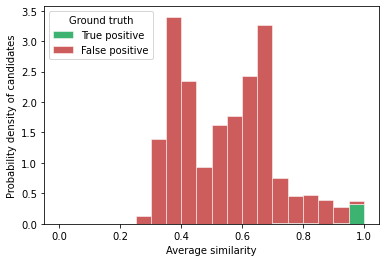

In [40]:
# Show the distribution of average similarity for the validated candidate link records 
# Non-place enriched
display_false_true(df=all_validation_subset, column='avg_similarity', 
                   xlabel='Average similarity', ylabel='Probability density of candidates',
                  density=True)

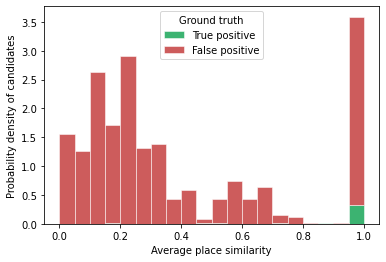

In [41]:
# Show the distribution of average place similarity for the validated candidate link records 
# Non-place enriched
display_false_true(df=all_validation_subset, column='avg_place_sim', 
                   xlabel='Average place similarity', ylabel='Probability density of candidates')

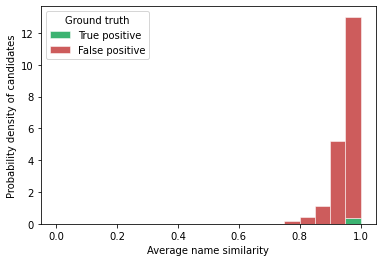

In [42]:
# Show the distribution of average name similarity for the validated candidate link records 
# Non-place enriched
display_false_true(df=all_validation_subset, column='avg_name_sim', 
                   xlabel='Average name similarity', ylabel='Probability density of candidates')

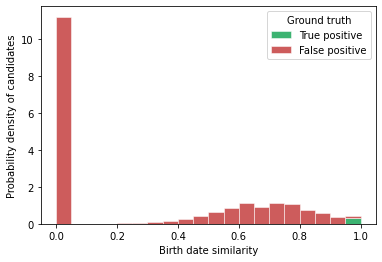

In [43]:
# Show the distribution of birth date similarity for the validated candidate link records 
# Non-place enriched
display_false_true(df=all_validation_subset, column='birth_date_sim', 
                   xlabel='Birth date similarity', ylabel='Probability density of candidates')

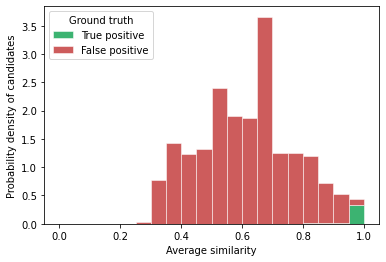

In [44]:
# Show the distribution of average similarity for the validated candidate link records 
# Place enriched
display_false_true(df=all_validation_enriched_subset, column='avg_similarity', 
                   xlabel='Average similarity', ylabel='Probability density of candidates')

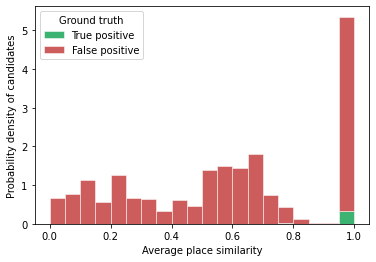

In [45]:
# Show the distribution of average place similarity for the validated candidate link records 
# Place enriched
display_false_true(df=all_validation_enriched_subset, column='avg_place_sim', 
                   xlabel='Average place similarity', ylabel='Probability density of candidates')

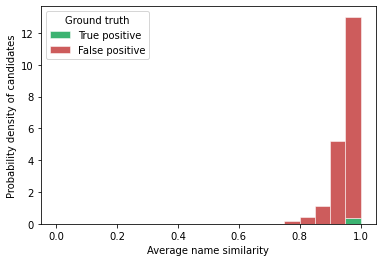

In [46]:
# Show the distribution of average name similarity for the validated candidate link records 
# Place enriched
display_false_true(df=all_validation_enriched_subset, column='avg_name_sim', 
                   xlabel='Average name similarity', ylabel='Probability density of candidates')

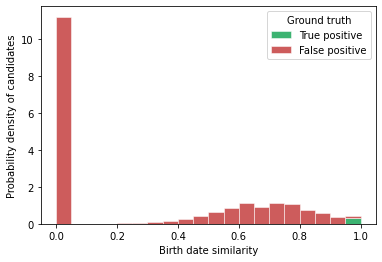

In [47]:
# Show the distribution of birth date similarity for the validated candidate link records 
# Place enriched
display_false_true(df=all_validation_enriched_subset, column='birth_date_sim', 
                   xlabel='Birth date similarity', ylabel='Probability density of candidates')

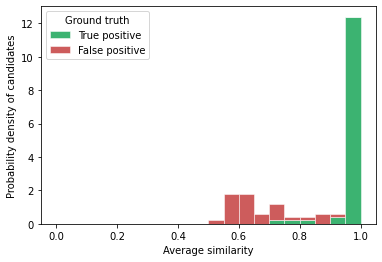

In [48]:
# Create the same plots (in the same order) for just the manually validated candidate links
# Non-place enriched
display_false_true(df=validation_sim, column='avg_similarity', 
                   xlabel='Average similarity', ylabel='Probability density of candidates',
                  density=True)

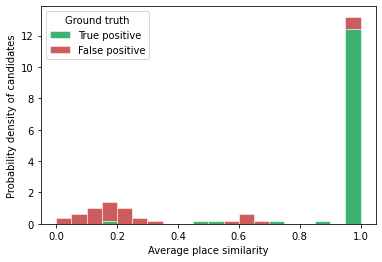

In [49]:
# Non-place enriched
display_false_true(df=validation_sim, column='avg_place_sim', 
                   xlabel='Average place similarity', ylabel='Probability density of candidates',
                  density=True)

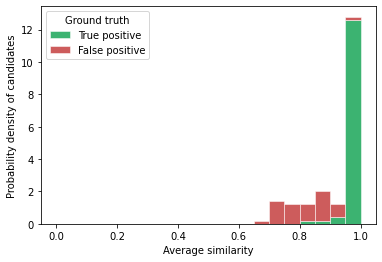

In [50]:
# Place-enriched
display_false_true(df=validation_sim_enriched, column='avg_similarity', 
                   xlabel='Average similarity', ylabel='Probability density of candidates',
                  density=True)

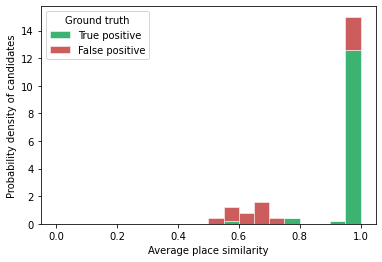

In [51]:
# Place enriched
display_false_true(df=validation_sim_enriched, column='avg_place_sim', 
                   xlabel='Average place similarity', ylabel='Probability density of candidates',
                  density=True)

In [55]:
# Show values of validated candidate links (without the identifiers of records that
# link to privacy-sensitive data)
all_validation_enriched_subset.loc[
    :,~all_validation_enriched_subset.columns.isin(['passport_id', 'person_card_id'])]

ground_truth  first_name_sim  last_name_sim  avg_name_sim  \
0            False        1.000000            1.0      1.000000   
1            False        1.000000            1.0      1.000000   
2            False        1.000000            1.0      1.000000   
3            False        1.000000            1.0      1.000000   
4            False        1.000000            1.0      1.000000   
...            ...             ...            ...           ...   
3729         False        0.876461            1.0      0.938231   
3730         False        1.000000            1.0      1.000000   
3731          True        1.000000            1.0      1.000000   
3732          True        1.000000            1.0      1.000000   
3733          True        1.000000            1.0      1.000000   

      birth_date_sim  place_name_sim  country_name_sim  province_name_sim  \
0           0.000000        0.300000               1.0                NaN   
1           0.000000        0.300000               1.0                NaN   
2           0.000000        0.300000               1.0                NaN   
3           0.000000        0.300000               1.0                NaN   
4           0.000000        0.300000               1.0                NaN   
...              ...             ...               ...                ...   
3729        0.620609        0.090909               1.0                NaN   
3730        0.711470        0.222222               1.0                NaN   
3731        1.000000             NaN               NaN                NaN   
3732        1.000000             NaN               NaN                NaN   
3733        1.000000             NaN               NaN                NaN   

      coordinate_sim  avg_place_sim  avg_similarity  
0           0.931066       0.743689        0.581230  
1           0.931066       0.743689        0.581230  
2           0.931066       0.743689        0.581230  
3           0.931066       0.743689        0.581230  
4           0.931066       0.743689        0.581230  
...              ...            ...             ...  
3729        0.411742       0.500884        0.686575  
3730        0.739413       0.653878        0.788449  
3731             NaN       1.000000        1.000000  
3732             NaN       1.000000        1.000000  
3733             NaN       1.000000        1.000000  

[3734 rows x 11 columns]

In [56]:
# Determine the difference between similarity scores of validation results
# Higher values mean that place enrichment increased the similarity score, else decreased
all_validation_difference = all_validation_enriched_subset.loc[
    :,~all_validation_enriched_subset.columns.isin(['passport_id', 'person_card_id', 
                                                    'ground_truth'])] - \
    all_validation_subset.loc[:,~all_validation_subset.columns.isin([
    'passport_id', 'person_card_id', 'ground_truth'])]
all_validation_difference['passport_id'] = all_validation_enriched_subset['passport_id']
all_validation_difference['person_card_id'] = all_validation_enriched_subset['person_card_id']
all_validation_difference['ground_truth'] = all_validation_enriched_subset['ground_truth']

In [58]:
# Do the same for just the manually validated candidate links
validation_difference = validation_sim_enriched.loc[
    :,~validation_sim_enriched.columns.isin(['passport_id', 'person_card_id', 
                                             'ground_truth'])] - \
    validation_sim.loc[:,~validation_sim.columns.isin([
    'passport_id', 'person_card_id', 'ground_truth'])]
validation_difference['passport_id'] = validation_sim_enriched['passport_id']
validation_difference['person_card_id'] = validation_sim_enriched['person_card_id']
validation_difference['ground_truth'] = validation_sim_enriched['ground_truth']

In [59]:
# Inspect statistics of difference between non- and place-enriched
all_validation_difference.describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count          3733.0         3734.0        3734.0          3734.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count     2744.000000        412.000000               37.0             0.0   
mean        -0.000273          0.019920                0.0             NaN   
std          0.012898          0.114487                0.0             NaN   
min         -0.272727         -0.376190                0.0             NaN   
25%          0.000000          0.000000                0.0             NaN   
50%          0.000000          0.000000                0.0             NaN   
75%          0.000000          0.000000                0.0             NaN   
max          0.176471          0.900000                0.0             NaN   

       avg_place_sim  avg_similarity    passport_id  
count    3734.000000     3734.000000    3734.000000  
mean        0.195491        0.065164   65600.828334  
std         0.268960        0.089653   47380.491409  
min        -0.323718       -0.107906      13.000000  
25%         0.000000        0.000000   21817.000000  
50%         0.000000        0.000000   52239.000000  
75%         0.388675        0.129558  115254.000000  
max         1.000000        0.333333  141355.000000

In [60]:
validation_difference.describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count           100.0          100.0         100.0           100.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count       27.000000          4.000000                0.0             0.0   
mean        -0.006199         -0.094048                NaN             NaN   
std          0.034074          0.188095                NaN             NaN   
min         -0.176471         -0.376190                NaN             NaN   
25%          0.000000         -0.094048                NaN             NaN   
50%          0.000000          0.000000                NaN             NaN   
75%          0.000000          0.000000                NaN             NaN   
max          0.009091          0.000000                NaN             NaN   

       avg_place_sim  avg_similarity    passport_id  
count     100.000000      100.000000     100.000000  
mean        0.156610        0.052203   61627.160000  
std         0.276922        0.092307   48656.285303  
min        -0.188095       -0.062698    1044.000000  
25%         0.000000        0.000000   17959.250000  
50%         0.000000        0.000000   43395.500000  
75%         0.350816        0.116939  113655.750000  
max         1.000000        0.333333  141281.000000

In [61]:
# Inspect statistics only for true positives
all_validation_difference[all_validation_difference.ground_truth==True].describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count            67.0           67.0          67.0            67.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count        6.000000           1.00000                0.0             0.0   
mean        -0.029412          -0.37619                NaN             NaN   
std          0.072044               NaN                NaN             NaN   
min         -0.176471          -0.37619                NaN             NaN   
25%          0.000000          -0.37619                NaN             NaN   
50%          0.000000          -0.37619                NaN             NaN   
75%          0.000000          -0.37619                NaN             NaN   
max          0.000000          -0.37619                NaN             NaN   

       avg_place_sim  avg_similarity    passport_id  
count      67.000000       67.000000      67.000000  
mean        0.018474        0.006158   59505.507463  
std         0.112699        0.037566   47250.177165  
min        -0.188095       -0.062698    1044.000000  
25%         0.000000        0.000000   18843.000000  
50%         0.000000        0.000000   42741.000000  
75%         0.000000        0.000000  109982.000000  
max         0.818182        0.272727  141281.000000

In [62]:
validation_difference[validation_difference.ground_truth==True].describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count            67.0           67.0          67.0            67.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count        6.000000           1.00000                0.0             0.0   
mean        -0.029412          -0.37619                NaN             NaN   
std          0.072044               NaN                NaN             NaN   
min         -0.176471          -0.37619                NaN             NaN   
25%          0.000000          -0.37619                NaN             NaN   
50%          0.000000          -0.37619                NaN             NaN   
75%          0.000000          -0.37619                NaN             NaN   
max          0.000000          -0.37619                NaN             NaN   

       avg_place_sim  avg_similarity    passport_id  
count      67.000000       67.000000      67.000000  
mean        0.018474        0.006158   59505.507463  
std         0.112699        0.037566   47250.177165  
min        -0.188095       -0.062698    1044.000000  
25%         0.000000        0.000000   18843.000000  
50%         0.000000        0.000000   42741.000000  
75%         0.000000        0.000000  109982.000000  
max         0.818182        0.272727  141281.000000

In [63]:
# Describe statistics for only false positives
all_validation_difference[all_validation_difference.ground_truth==False].describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count          3666.0         3667.0        3667.0          3667.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count     2738.000000        411.000000               37.0             0.0   
mean        -0.000210          0.020883                0.0             NaN   
std          0.012465          0.112941                0.0             NaN   
min         -0.272727          0.000000                0.0             NaN   
25%          0.000000          0.000000                0.0             NaN   
50%          0.000000          0.000000                0.0             NaN   
75%          0.000000          0.000000                0.0             NaN   
max          0.176471          0.900000                0.0             NaN   

       avg_place_sim  avg_similarity    passport_id  
count    3667.000000     3667.000000    3667.000000  
mean        0.198726        0.066242   65712.196346  
std         0.269907        0.089969   47381.999981  
min        -0.323718       -0.107906      13.000000  
25%         0.000000        0.000000   21925.000000  
50%         0.006714        0.002238   52356.000000  
75%         0.388889        0.129630  115290.500000  
max         1.000000        0.333333  141355.000000

In [64]:
validation_difference[validation_difference.ground_truth==True].describe()

first_name_sim  last_name_sim  avg_name_sim  birth_date_sim  \
count            67.0           67.0          67.0            67.0   
mean              0.0            0.0           0.0             0.0   
std               0.0            0.0           0.0             0.0   
min               0.0            0.0           0.0             0.0   
25%               0.0            0.0           0.0             0.0   
50%               0.0            0.0           0.0             0.0   
75%               0.0            0.0           0.0             0.0   
max               0.0            0.0           0.0             0.0   

       place_name_sim  country_name_sim  province_name_sim  coordinate_sim  \
count        6.000000           1.00000                0.0             0.0   
mean        -0.029412          -0.37619                NaN             NaN   
std          0.072044               NaN                NaN             NaN   
min         -0.176471          -0.37619                NaN             NaN   
25%          0.000000          -0.37619                NaN             NaN   
50%          0.000000          -0.37619                NaN             NaN   
75%          0.000000          -0.37619                NaN             NaN   
max          0.000000          -0.37619                NaN             NaN   

       avg_place_sim  avg_similarity    passport_id  
count      67.000000       67.000000      67.000000  
mean        0.018474        0.006158   59505.507463  
std         0.112699        0.037566   47250.177165  
min        -0.188095       -0.062698    1044.000000  
25%         0.000000        0.000000   18843.000000  
50%         0.000000        0.000000   42741.000000  
75%         0.000000        0.000000  109982.000000  
max         0.818182        0.272727  141281.000000

In [65]:
# Check if normal distribution of similarity values
stats.shapiro(all_validation_enriched_subset['avg_similarity'])

ShapiroResult(statistic=0.9842503070831299, pvalue=5.510014850103374e-20)

In [66]:
stats.shapiro(all_validation_enriched_subset['avg_place_sim'])

ShapiroResult(statistic=0.9114758372306824, pvalue=3.171138424767061e-42)

In [67]:
stats.shapiro(validation_sim_enriched['avg_similarity'])

ShapiroResult(statistic=0.7280778884887695, pvalue=2.5619742872323714e-12)

In [68]:
stats.shapiro(validation_sim_enriched['avg_place_sim'])

ShapiroResult(statistic=0.5813814401626587, pvalue=1.9329211388213145e-15)

In [69]:
# Wilcoxon signed-rank test applied because not normally distributed
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(all_validation_subset['avg_similarity'], 
                                             all_validation_enriched_subset['avg_similarity'])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 63291.0 with p-value 6.0264988134756645e-301


In [70]:
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(validation_sim['avg_similarity'], 
                                             validation_sim_enriched['avg_similarity'])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 10.0 with p-value 8.867009639231229e-07


In [75]:
# Only on true positives 
# (gives same as below because the only true positives are from manual validation)
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(
    all_validation_subset['avg_similarity'][all_validation_subset.ground_truth==True], 
    all_validation_enriched_subset['avg_similarity'][all_validation_enriched_subset.ground_truth==True])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 2.0 with p-value 0.13801073756865956


C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [74]:
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(
    validation_sim['avg_similarity'][validation_sim.ground_truth==True], 
    validation_sim_enriched['avg_similarity'][validation_sim_enriched.ground_truth==True])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 2.0 with p-value 0.13801073756865956


C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [76]:
# Only on false positives
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(
    all_validation_subset['avg_similarity'][all_validation_subset.ground_truth==False], 
    all_validation_enriched_subset['avg_similarity'][all_validation_enriched_subset.ground_truth==False])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 62556.0 with p-value 1.7631022601049296e-300


In [77]:
wilcoxon_avg_sim, p_avg_sim = stats.wilcoxon(
    validation_sim['avg_similarity'][validation_sim.ground_truth==False], 
    validation_sim_enriched['avg_similarity'][validation_sim_enriched.ground_truth==False])
print("Wilcoxon signed-rank test value", wilcoxon_avg_sim, "with p-value", p_avg_sim)

Wilcoxon signed-rank test value 3.0 with p-value 3.5149630812742274e-06
